# Generation of figure 3
Tim Tyree<br>
9.20.2022

In [86]:
from lib.my_initialization import *
from lib import *  
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt, numpy as np
from mpltools import annotation
import random,scipy
import matplotlib as mpl #for colorbar
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
from scipy import stats
darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
import warnings
warnings.simplefilter("ignore", UserWarning)
# import cupy as cp
np.random.seed(42)
# cp.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
#reset matplotlib
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [88]:
#DONT: dev PlotScatter function for the full models
#reset matplotlib
mpl.rcParams.update(matplotlib.rcParamsDefault)

# define module

# make plot showing alinear controls annihilation rate exponent

In [89]:
#load birth death rates from the full model
data_folder=f'{nb_dir}/data'
os.chdir(data_folder)

data_fk_fn='full_results/data_fig4_vidmar_fk_tt.csv'
data_lr_fn='full_results/data_fig4_vidmar_lr_tt.csv'

fk=pd.read_csv(data_fk_fn)
fk['N']=fk['No2']*2
fk['q']=fk['N']/fk['A'] #number of tips per square centimeter
fk['w']=fk['rate']/fk['A']*10**3 #Hz/cm^2

lr=pd.read_csv(data_lr_fn)
lr['N']=lr['No2']*2
lr['q']=lr['N']/lr['A'] #number of tips per square centimeter
lr['w']=lr['rate']/lr['A']*10**3 #Hz/cm^2

In [90]:
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_18_all_powerlaw_fits.csv"
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_17_all_powerlaw_fits.csv"
input_fn=f"{nb_dir}/data/osg_output/run_15_all_powerlaw_fits.csv" #works for many parameter settings (L=10)
df=pd.read_csv(input_fn)
df.head()

,m,Delta_m,M,Delta_M,Rsq,rmse,rmse_full,model_name_full,q_min,q_max,...,D,varkappa,x0,L,force_code,neighbor,reflect,set_second,no_repulsion,no_attraction
0,1.477497,0.017889,10.233038,0.458553,0.996691,0.254568,2.192560,fk_ncbc,0.1,1.0,...,1.6,9,0,10,2,0,0,0,0,0
1,1.726534,0.013938,18.451423,0.663628,0.998526,0.252599,0.849591,lr_pbc,0.1,1.0,...,1.0,9,0,10,2,0,1,0,0,0
2,1.361442,0.010685,34.324471,1.345462,0.998607,0.557511,10.602247,lr_pbc,0.1,1.0,...,1.2,90,0,10,2,0,1,0,0,0
3,3.050656,0.082928,110.878921,27.313205,0.983541,8.696932,40.571684,lr_pbc,0.1,1.0,...,1.6,1,0,10,2,0,0,0,0,0
4,1.961670,0.014691,3.008488,0.072870,0.998732,0.053220,1.228204,fk_pbc,0.1,1.0,...,1.9,1,0,10,2,0,0,0,0,0


In [91]:
r=0.1
kappa=500#250
# kappa=250
# D=0.7
D=0.7
# varkappa_lst=sorted(set(df['varkappa'].values))
# varkappa_lst

#TODO: extract xy values for kappa, r, D fixed to any value, which I can change later
#define constant parameters
reflect=0
force_code=2
set_second=0
neighbor=0
no_attraction=0
no_repulsion=0
reflect=0
# kappa=100
L=10

#template query for the DataFrame
query =(df.set_second==set_second)
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
query&=(df.reflect==reflect)
query&=df.r==r
query&=df.kappa==kappa
query&=df.D==D
query&=df.L==L
# query&=df.x0==x0
query_template=query.copy()

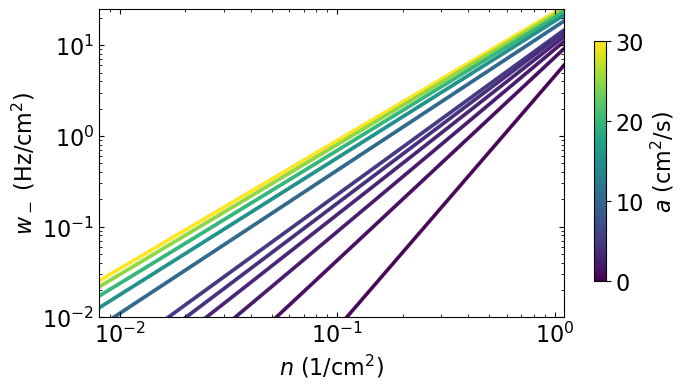

In [92]:
# cmap = 'Spectral_r'
cmap = 'viridis'
num_points = 25
c_col = 'rmse_full'
# fontsize = 20
fontsize=16
xytext = (0.09, 10)
# x1lim=[5,10]
# x2lim=[50,350]
# x1lim = [8e-2, 1.1]  
# x1lim = [0.008, 11.0]
# x2lim = [0.01, 250.0]
x2lim = [1e-2, 25]
x1lim = [8e-3, 1.1]  
show_full_models=False

# x_values = np.linspace(0, 1, 1000)
x_values = np.logspace(-3, .4, 1000)


figsize = (6, 4)  #(5,4)
fig, ax = plt.subplots(figsize=figsize)

# #plot the particle models
# varkappa_lst = sorted(set(df['varkappa'].values))
# varkappa_lst = list(reversed([0,1,2,3, 5, 10, 20, 30]))
# varkappa_lst = list(reversed([0, 1, 2, 5, 15, 30]))
varkappa_lst = list(reversed([0, 
                              1, 2, 3, 4,
 5,
#  6,
#  7,
#  8,
#  9,
 10, 15, 20, 25, 30]))

# varkappa_set_values = sorted(df.varkappa.drop_duplicates())
# varkappa_lst = list(varkappa_set_values)

vmin = 0
# vmin = 0.01
vmax = 30  #np.max(varkappa_lst)
for varkappa in varkappa_lst:
    #extract the data
    query = query_template.copy()
    query &= df.varkappa == varkappa
    M_returned = df.loc[query, 'M'].values
    nu_returned = df.loc[query, 'm'].values
    #     print((M_returned.shape,nu_returned.shape))  #shows there is a unique fit recalled from cache
    M = M_returned[0]
    nu = nu_returned[0]
    y_values = M * x_values**nu
    c_values = varkappa + 0. * x_values
    #plot
    ax.scatter(x_values,
               y_values,
               c=c_values,
               cmap=cmap,
               alpha=0.6,
               s=3,
               vmin=vmin,
               vmax=vmax)
# title=f'Top {num_points} Trials for {modelname} Model\n'
FormatAxes(
    ax,
    x1lim=x1lim,
    x2lim=x2lim,
#     x1label=r'$N/A$ (1/cm$^{2}$)',  #r'$q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
#     x2label=    r'$W_{-2}/A$ (Hz/cm$^{2}$)',  #r'$w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
#     x1label=r'$q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
    x1label=r'$n$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
    x2label=r'$w_-$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
    title=None,
    fontsize=fontsize,
    use_loglog=True)
# cbar=fig.colorbar(cmap='bone', ax=ax, shrink=0.6,label=r'RMSE$_{particle\;vs\;full}$')#, location='top'
# fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
#     cbar=fig.colorbar(pcm, ax=axs[:, col],shrink=0.6)#,label=output_col)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
cmap_obj = mpl.cm.get_cmap(cmap)
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax,
                               cmap=cmap_obj,
                               norm=norm,
                               spacing='proportional')
cb.set_label(r'$a$ (cm$^{2}/$s)', fontsize=fontsize)
cb.ax.tick_params(labelsize=fontsize)
ax.tick_params(top=True, right=True,direction='in',which='both')

if show_full_models:
    #plot the full models
    ax.scatter(fk['q'].values,
               fk['w'].values,
               c='C0',
               alpha=0.2,
               s=40,
               label='Fenton-Karma',
               zorder=0)
    ax.scatter(lr['q'].values,
               lr['w'].values,
               c='C1',
               alpha=0.2,
               s=40,
               label='Luo-Rudy',
               zorder=0)

# #plot arrow annotation
# ax.annotate("decreasing a", xy=(0.3, 11), xytext=xytext, fontsize=fontsize)
# ax.annotate(
#     "",
#     xy=(0.5, 0.08),
#     xytext=(0.15, 8),  #,zorder=-1e8,#zorder can send to back
#     arrowprops=dict(lw=3, headwidth=20., headlength=20., color='k',
#                     alpha=0.8))  #arrowstyle="->",

#TODO: add dashed-black line below a=0 with slope of exactly two
# #TODO: mark the slope of ^that line with ~2
# x1 = 0.09
# y1 = 2
# annotation.slope_marker(origin=(x1, y1),
#                         slope=2,
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
#                         ax=ax)
# #DONE: mark the slope of ^that line with ~3
# x1 = 0.6
# y1 = 0.3
# annotation.slope_marker(origin=(x1, y1),
#                         slope=3,#(3, 1),
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
#                         ax=ax)

# # #DONE: test whether this slope is correct with a scatter plot of 2 points
# # x2 = 0.7
# # y2 = y1 * (x2 / x1)**3
# # ax.scatter([x1,x2],[y1,y2],marker='^',c='r',s=100,zorder=-1)
# # #DONT: if not, dev my own custom loglog slope plotter
# leg = ax.legend(loc='lower right', fontsize=fontsize - 6)
# for lh in leg.legendHandles:
#     lh.set_alpha(1)
plt.show()

In [93]:
df_increasing_alinear_lst=[]

for varkappa in varkappa_lst:
    #extract the data
    query = query_template.copy()
    query &= df.varkappa == varkappa
    M_returned = df.loc[query, 'M'].values
    nu_returned = df.loc[query, 'm'].values
    #     print((M_returned.shape,nu_returned.shape))  #shows there is a unique fit recalled from cache
    M = M_returned[0]
    nu = nu_returned[0]
    
    y_values = M * x_values**nu
    df_increasing_alinear_lst.append( df.loc[query].copy())
df_increasing_alinear = pd.concat(df_increasing_alinear_lst)
df_increasing_alinear

,m,Delta_m,M,Delta_M,Rsq,rmse,rmse_full,model_name_full,q_min,q_max,...,D,varkappa,x0,L,force_code,neighbor,reflect,set_second,no_repulsion,no_attraction
7429,1.414269,0.014243,23.118618,1.024507,0.997708,0.403004,4.252182,lr_pbc,0.1,1.0,...,0.7,30,0,10,2,0,0,0,0,0
6038,1.433465,0.014162,21.797745,0.955647,0.997794,0.416148,3.503973,lr_pbc,0.1,1.0,...,0.7,25,0,10,2,0,0,0,0,0
1830,1.467008,0.015734,20.272675,0.946421,0.997402,0.432084,2.626290,lr_pbc,0.1,1.0,...,0.7,20,0,10,2,0,0,0,0,0
815,1.509936,0.017421,18.492366,0.886283,0.996994,0.382446,1.549670,lr_pbc,0.1,1.0,...,0.7,15,0,10,2,0,0,0,0,0
2447,1.578557,0.020413,15.840945,0.853601,0.996227,0.407603,0.387474,lr_pbc,0.1,1.0,...,0.7,10,0,10,2,0,0,0,0,0
7458,1.741112,0.022624,12.407240,0.658901,0.996191,0.342691,2.070674,lr_ncbc,0.1,1.0,...,0.7,5,0,10,2,0,0,0,0,0
6064,1.806296,0.021015,11.551250,0.541115,0.996944,0.277960,2.401079,fk_ncbc,0.1,1.0,...,0.7,4,0,10,2,0,0,0,0,0
4686,1.881844,0.022072,10.333632,0.499313,0.996894,0.272578,1.704260,fk_ncbc,0.1,1.0,...,0.7,3,0,10,2,0,0,0,0,0
62,2.011196,0.019625,9.017047,0.388719,0.997848,0.222177,0.906878,fk_ncbc,0.1,1.0,...,0.7,2,0,10,2,0,0,0,0,0
2817,2.238748,0.013674,7.352802,0.197231,0.999156,0.106129,0.259246,fk_ncbc,0.1,1.0,...,0.7,1,0,10,2,0,0,0,0,0


In [94]:
df_increasing_alinear['alinear'] = df_increasing_alinear['varkappa']
df_increasing_alinear['nu_minus'] = df_increasing_alinear['m']
df_increasing_alinear['M_minus'] = df_increasing_alinear['M']
df_increasing_alinear['Delta_nu_minus'] = df_increasing_alinear['Delta_m']
df_increasing_alinear['Delta_M_minus'] = df_increasing_alinear['Delta_M']


In [95]:
#save to pickle
saving=True
saving=False
if saving:
    death_rate_versus_alinear_dir=f'{nb_dir}/data/full_results/data_fig4_tymura_increasing_alinear.pkl'
    data_lr_fn='full_results/data_fig4_vidmar_lr_tt.csv'
    df_death_rate_versus_alinear = df_increasing_alinear[['alinear','nu_minus','M_minus','Delta_nu_minus','Delta_M_minus']]
    dict_data = dict(df_death_rate_versus_alinear=df_death_rate_versus_alinear,
                     df_increasing_alinear=df_increasing_alinear)
    save_to_pickle(death_rate_versus_alinear_dir, dict_data)
    print(f"{death_rate_versus_alinear_dir=}")


In [96]:
varkappa_lst

[30, 25, 20, 15, 10, 5, 4, 3, 2, 1, 0]

## plot the exponents of the above powerlaw fits

In [97]:
# xytext = (0.09, 10)
# # x1lim=[5,10]
# # x2lim=[50,350]
# # x1lim = [8e-2, 1.1]  
# # x1lim = [0.008, 11.0]
# # x2lim = [0.01, 250.0]
# x2lim = [1e-2, 25]
# x1lim = [8e-3, 1.1]  
# show_full_models=False


In [98]:
df.loc[query]

,m,Delta_m,M,Delta_M,Rsq,rmse,rmse_full,model_name_full,q_min,q_max,...,D,varkappa,x0,L,force_code,neighbor,reflect,set_second,no_repulsion,no_attraction
1844,2.78225,0.012605,4.580904,0.11112,0.999535,0.061705,0.887947,fk_pbc,0.1,1.0,...,0.7,0,0,10,2,0,0,0,0,0


In [99]:
# x_values = np.linspace(0, 1, 1000)
x_values = np.logspace(-3, .4, 1000)
varkappa_set_values = sorted(df.varkappa.drop_duplicates())
# vmin = 0
# # vmin = 0.01
# vmax = 30  
dict_graph_lst=[]
for varkappa in varkappa_set_values:
    #extract the data
    query = query_template.copy()
    query &= df.varkappa == varkappa
    M_returned = df.loc[query, 'M'].values
    nu_returned = df.loc[query, 'm'].values
    D_returned = df.loc[query, 'D'].values
#     #     print((M_returned.shape,nu_returned.shape))  #shows there is a unique fit recalled from cache
#     M = M_returned[0]
#     nu = nu_returned[0]
#     y_values = M * x_values**nu
#     c_values = varkappa + 0. * x_values
#     #plot
#     ax.scatter(x_values,
#                y_values,
#                c=c_values,
#                cmap=cmap,
#                alpha=0.6,
#                s=3,
#                vmin=vmin,
#                vmax=vmax)
    for M,nu,D in zip(M_returned,nu_returned,D_returned):
        dict_graph_lst.append(dict(M=M,nu=nu,varkappa=varkappa,D=D))
df_graph = pd.DataFrame(dict_graph_lst)
# df_graph

In [100]:
# df_graph

In [101]:
np.sqrt(9/5)

1.3416407864998738

In [102]:
1

1

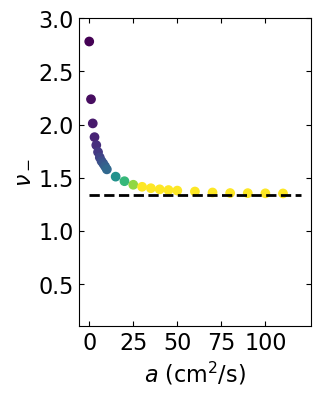

In [103]:
# cmap = 'Spectral_r'
cmap = 'viridis'
num_points = 25
c_col = 'rmse_full'
# fontsize = 20
fontsize=16
figsize = (3, 4)  #(5,4)
fig, ax = plt.subplots(figsize=figsize)

# df_graph.plot.scatter(ax=ax,x='varkappa',y='nu',c='varkappa',vmin=vmin,vmax=vmax,cmap='viridis')#,alpha=0.7,size=50)
varkappa_values = df_graph['varkappa'].values
nu_values = df_graph['nu'].values
ax.scatter(x=varkappa_values,y=nu_values,c=varkappa_values,vmin=vmin,vmax=vmax,cmap='viridis')#,alpha=0.7,size=50)
# df_graph.plot(ax=ax,x='varkappa',y='nu')#,alpha=0.7,size=50)


#TODO: plot dotted line at 4/3
xv=np.linspace(0,120,10)
ax.plot(xv,0.*xv+4/3,'k--',lw=2)


ax.set_xticks([0,25,50,75,100])
ax.tick_params(top=True, right=True,direction='in',which='both')
format_plot(ax=ax,xlabel=r'$a$ (cm$^2$/s)',ylabel=r'$\nu_-$',use_loglog=False,fontsize=fontsize)
# ax.set_xscale('log')
# fig.colorbar().remove() 
# ax.set_yscale('log')
# ax.get_legend().remove()
# cb = plt.colorbar() 
# cb.remove() 



ax.set_ylim([0.1,3])
plt.show()

# generate updated rate plot of fits

In [104]:
#TODO: copy cells for existing panel
#TODO: make the two panels agree in terms of fontsize and axis limits.

# build minimum dataset from best fits cached for either of the full models at either of the length scales

In [105]:
kwargs = dict(data_fk_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_fk_tt.csv',
              data_lr_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_lr_tt.csv',
             min_num_particles=9)

In [108]:
latest_run_num=29
run_num_lst = list(reversed(list(np.arange(14,latest_run_num+1))))
# run_num_lst=[25,17]
# run_num_lst=[25,19]
# run_num_lst=[25,24]
# run_num_lst = list(np.arange(12,26))
# run_num_lst = list(np.arange(26,14))
run_num_lst=[25,18]
# run_num_lst=[28,18]
run_num_lst=[28,29]
# run_num_lst=[25,29]
# run_num_lst=[32,29]
run_num_lst=[32,29]
#note 31==30...
# run_num_lst=[28,29]  #what is in Particle_Paper
run_num_lst=[32,33]  

use_filterby_neighbor=True
# neighbor=0
neighbor=1

use_filterby_minN=True
minN=9

use_filterby_amax=True
min_amax=1.

# neighbor=1
remove_no_diffusion=True
# Dinf=0
Dinf=0.01
num_digits_round_amax=3
# run_num=25 #L=5 cm
# run_num=18 #L=10 cm
gmin_fk_lst=[]
gmin_lr_lst=[]
log_dir_fk_lst=[]
log_dir_lr_lst=[]
dict_results_fk_lst=[]
dict_results_lr_lst=[]
# for run_num in [25,18]: #chosen exemplar pair
for run_num in run_num_lst:
    parquet_dir_defects_fk=f'{nb_dir}/data/osg_output/run_{run_num}_defects_to_fk.parquet'
    parquet_dir_defects_lr=f'{nb_dir}/data/osg_output/run_{run_num}_defects_to_lr.parquet'
    input_folder=f'{nb_dir}/data/osg_output/run_{run_num}_all'
#     parquet_dir_defects_fk=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_fk.parquet'
#     parquet_dir_defects_lr=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_defects_to_lr.parquet'
#     input_folder=f'/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all'
    #load data
    df_defects_fk=pd.read_parquet(parquet_dir_defects_fk)
    df_defects_lr=pd.read_parquet(parquet_dir_defects_lr)
    
    #filterby neighbor
    if use_filterby_neighbor:
        df_defects_fk = df_defects_fk[df_defects_fk['neighbor']==neighbor].copy()
        df_defects_lr = df_defects_lr[df_defects_lr['neighbor']==neighbor].copy()
    
    #compute order parameter for each member a=amax-2*D
    #add columns for amax
    df_defects_fk['amax'] = np.around(df_defects_fk['varkappa'] + 2.*df_defects_fk['D'],num_digits_round_amax)
    df_defects_lr['amax'] = np.around(df_defects_lr['varkappa'] + 2.*df_defects_lr['D'],num_digits_round_amax)
    
    if remove_no_diffusion:
        df_defects_fk = df_defects_fk[df_defects_fk['D']>Dinf].copy()
        df_defects_lr = df_defects_lr[df_defects_lr['D']>Dinf].copy()
        
    if use_filterby_amax:
        df_defects_fk = df_defects_fk[df_defects_fk['amax']>min_amax].copy()
        df_defects_lr = df_defects_lr[df_defects_lr['amax']>min_amax].copy()
        
    
    #identify the lowest error simulation for each amax value
    print(f"\n**************************************")
    print(f"* Fenton-Karma Model (best settings):")
    print(f"**************************************")
    minrmse=9999.
    supamax=40.
    #supamax=1.8
    #supamax=40.
    for amax,g in df_defects_fk.groupby(by='amax'):
        rmse_min = g['rmse'].min()
        count = g['rmse'].count()
        log_likelihood = g['log_likelihood'].max()
        if (rmse_min<=minrmse)&(amax<=supamax):
            minrmse=rmse_min
            gmin_fk=g.copy()
            print_str =f"{amax=:.4f}, {rmse_min=:.4f}, {log_likelihood=:.4f}, {count=}"
    print(print_str)
    gmin_fk.sort_values(by='D',inplace=True)
    

    #find best simulation for the full model at this avalue
#     dg_fk=gmin_fk[gmin_fk['rmse'] == gmin_fk['rmse'].min()].copy()
    dg_fk=gmin_fk[gmin_fk['log_likelihood'] == gmin_fk['log_likelihood'].max()].copy()
    dg_fk['run']=run_num
    df_defects_fk['run']=run_num
    dg_fk['model']='Fenton-Karma'
    cluster_index,job_index = dg_fk[['cluster_index','job_index']].values.T
    input_fn = os.path.join(input_folder,f"job.out.{int(cluster_index)}.{int(job_index)}")
    #assert os.path.exists(input_fn)
    if os.path.exists(input_fn):
        input_fn_fk=input_fn
        df_fit_fk,dict_linear_fit_fk = routine_measure_annihilation_defect(input_fn,printing=True,**kwargs)
        amax_fk=dg_fk['amax'].median()
        rmse_fk=dg_fk['rmse'].median()
        L = dg_fk['L'].median()
        print(f"\nbest fit for Fenton-Karma: RMSE: {rmse_fk:.4f} Hz/cm^2, amax: {amax_fk:.4f} cm^2/s, L: {L} cm")
        print(f"{input_fn_fk=}")
        #record
        dict_results_fk=dict(
            model_name='Fenton-Karma',
            amax=amax_fk,
            rmse=rmse_fk,
            L=L,
            df_fit=df_fit_fk,
            dg_fit=dg_fk,
            dict_linear_fit=dict_linear_fit_fk,
            filename=input_fn_fk,
            gmin=gmin_fk)
        dict_results_fk_lst.append(dict_results_fk)
        gmin_fk_lst.append(gmin_fk)
        log_dir_fk_lst.append(input_fn)
    
    #identify the lowest error simulation for each amax value
    print(f"\n**************************************")
    print(f"* Luo-Rudy Model (best settings):")
    print(f"**************************************")
    minrmse=9999.
    supamax=40
    #supamax=10.2
    for amax,g in df_defects_lr.groupby(by='amax'):
        rmse_min = g['rmse'].min()
        count = g['rmse'].count()
        log_likelihood = g['log_likelihood'].max()
        if (rmse_min<=minrmse)&(amax<=supamax):
            minrmse=rmse_min
            gmin_lr=g.copy()
            print_str =f"{amax=:.4f}, {rmse_min=:.4f}, {log_likelihood=:.4f}, {count=}"
    print(print_str)        
    gmin_lr.sort_values(by='D',inplace=True)
    
    #find best simulation for the full model at this avalue
#     dg_lr=gmin_lr[gmin_lr['rmse'] == gmin_lr['rmse'].min()].copy()
    dg_lr=gmin_lr[gmin_lr['log_likelihood'] == gmin_lr['log_likelihood'].max()].copy()
    dg_lr['run']=run_num
    df_defects_fk['run']=run_num
    dg_lr['model']='Luo-Rudy'
    cluster_index,job_index = dg_lr[['cluster_index','job_index']].values.T
    input_fn = os.path.join(input_folder,f"job.out.{int(cluster_index)}.{int(job_index)}")
    #assert os.path.exists(input_fn)
    if os.path.exists(input_fn):
        input_fn_lr=input_fn
        df_fit_lr,dict_linear_fit_lr = routine_measure_annihilation_defect(input_fn,printing=True,**kwargs)
        amax_lr=dg_fk['amax'].median()
        rmse_lr=dg_lr['rmse'].median()
        L = dg_lr['L'].median()
        print(f"\nbest fit for Luo-Rudy: RMSE: {rmse_lr:.4f} Hz/cm^2, amax: {amax_lr:.4f} cm^2/s, L: {L} cm")
        print(f"{input_fn_lr=}")
        #record
        dict_results_lr=dict(
            model_name='Luo-Rudy',
            amax=amax_lr,
            rmse=rmse_lr,
            L=L,
            df_fit=df_fit_lr,
            dg_fit=dg_lr,
            dict_linear_fit=dict_linear_fit_lr,
            filename=input_fn_lr,
            gmin=gmin_lr)
        dict_results_lr_lst.append(dict_results_lr)
        gmin_lr_lst.append(gmin_lr)
        log_dir_lr_lst.append(input_fn)

    print(f"\nparameter range supported in run #{run_num}:")
    print(f"number of trials: {df_defects_lr.shape[0]}")
    print(df_defects_lr.describe()[['r','kappa','D','varkappa','amax','L','neighbor']].T[['min','max']].T)


**************************************
* Fenton-Karma Model (best settings):
**************************************
amax=1.8400, rmse_min=0.0654, log_likelihood=28.4301, count=1446

best fit for Fenton-Karma: RMSE: 0.0803 Hz/cm^2, amax: 1.8400 cm^2/s, L: 5.0 cm
input_fn_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_32_all/job.out.24363587.23195'

**************************************
* Luo-Rudy Model (best settings):
**************************************
amax=12.0170, rmse_min=0.0941, log_likelihood=22.7754, count=725

best fit for Luo-Rudy: RMSE: 0.0950 Hz/cm^2, amax: 1.8400 cm^2/s, L: 5.0 cm
input_fn_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_32_all/job.out.24363587.3366'

parameter range supported in run #32:
number of trials: 7241
         r    kappa       D  varkappa    amax    L  neighbor
min  0.010    48.64  0.0372    1.6112   1.840  5.0       1.0
max  0.195  1614.16  0.4158   11.1853  12.017  5.0       1.0

*************

# Plot mean annihilation rates

In [109]:
dict_wjr = recall_death_rates_vidmar_rappel(**kwargs)
fk=dict_wjr['fk']
lr=dict_wjr['lr']

In [110]:
# plot_death_rates_loglog_full

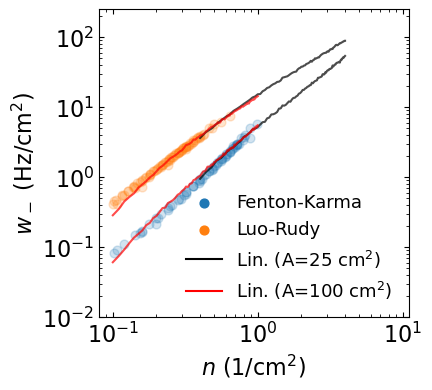

run_num_lst=[32, 33]
neighbor=1


In [111]:
use_filterby_minN=True
minN=10
# minN=8
# figsize = (6, 4)  #(5,4)
figsize = (4, 4)  #(5,4)
fontsize=16

# x1lim=[0.008, 11]
x1lim=[0.08, 11]
x2lim=[0.01, 250]


fig, ax = plt.subplots(figsize=figsize)



ax = plot_death_rates_loglog_full(fk,lr,ax=ax,fontsize=fontsize,x1lim=x1lim, x2lim=x2lim)

# Linear Particle (L=5)
df_fit_fk = dict_results_fk_lst[0]['df_fit'].copy()
dg_fit_fk = dict_results_fk_lst[0]['dg_fit'].copy()
df_fit_lr = dict_results_lr_lst[0]['df_fit'].copy()
dg_fit_lr = dict_results_lr_lst[0]['dg_fit'].copy()

if use_filterby_minN:
    df_fit_fk = df_fit_fk[df_fit_fk['N']>=minN].copy()
    df_fit_lr = df_fit_lr[df_fit_lr['N']>=minN].copy()

df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label=r'Lin. (A=25 cm$^2$)')#f'Lin. Particle (L=5)')
df_fit_lr.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label='_Best Fit to LR')
# df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label=r'Particle (A=25 cm$^2$)')#f'Lin. Particle (L=5)')
# df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label=r'Linear Particle (A=25 cm$^2$)')#f'Lin. Particle (L=5)')
# df_fit_lr.plot(x='q',y='w',alpha=0.7,ax=ax,color='k',label='_Best Fit to LR')

# Linear Particle (L=10)
df_fit_fk = dict_results_fk_lst[1]['df_fit'].copy()
dg_fit_fk = dict_results_fk_lst[1]['dg_fit'].copy()
df_fit_lr = dict_results_lr_lst[1]['df_fit'].copy()
dg_fit_lr = dict_results_lr_lst[1]['dg_fit'].copy()

if use_filterby_minN:
    df_fit_fk = df_fit_fk[df_fit_fk['N']>=minN].copy()
    df_fit_lr = df_fit_lr[df_fit_lr['N']>=minN].copy()

   
df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label=r'Lin. (A=100 cm$^2$)')#f'Lin. Particle (L=5)')
df_fit_lr.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label='_Best Fit to LR')
# df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label=r'Linear Particle (A=100 cm$^2$)')#)f'Lin. Particle (L=10)')
# # df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label=f'Linear Particle (L=10)')#,label='_Best Fit to FK')
# # df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label=r'Lin. Particle (A=100 cm$^2$)')#)f'Lin. Particle (L=10)')
# # df_fit_fk.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label=r'Particle (A=100 cm$^2$)')#)f'Lin. Particle (L=10)')
# df_fit_lr.plot(x='q',y='w',alpha=0.7,ax=ax,color='r',label='_Best Fit to LR')

# format_plot
ax.tick_params(top=True, right=True,direction='in',which='both')
format_plot(ax=ax,xlabel=r'$n$ (1/cm$^2$)',ylabel=r'$w_-$ (Hz/cm$^2$)',fontsize=fontsize,use_loglog=True)
# format_plot(ax=ax,xlabel=r'$q$ (1/cm$^2$)',ylabel=r'$w_-$ (Hz/cm$^2$)',fontsize=fontsize,use_loglog=True)
# ax.legend(loc='upper left',fontsize=fontsize-2)
# ax.legend(loc='lower right',fontsize=fontsize-2.,frameon=False,ncol=2)
# leg = ax.legend(loc=(1.04,0.2),fontsize=fontsize-2.,frameon=False)
# leg = ax.legend(loc='upper left',fontsize=fontsize-3.,frameon=False,ncol=1)
leg = ax.legend(loc='lower right',fontsize=fontsize-3.,frameon=False,ncol=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
# ax.get_legend().remove()

# x1lim = [8e-3, 1.1]  
# x2lim = [1e-2, 25]
# ax.set_xlim(x1lim)
# ax.set_ylim(x2lim)

#add annotation
# xytext=(0.09, 10)
# xytext=(0.01, 90)
# ax.annotate(r"best fit ($a>0$)", xy=xy, xytext=xytext,fontsize=fontsize)
# .tick_params(labelbottom=False, labeltop=True, labelleft=False, labelright=False,
#                      bottom=False, top=True, left=False, right=False)
# xytext=(0.01, 40)
# xy=(0.3, 11)
# ax.annotate(r"$a_{max}$ = const.", xy=xy, xytext=(0.01, 40),fontsize=fontsize-2)
# ax.annotate(r"$a_{max}$ fixed to observed", xy=xy, xytext=(0.01, 40),fontsize=fontsize-2)
# ax.annotate(r"$a_{max}$ fixed to observation"+f"\nfrom MSR of full", xy=xy, xytext=(0.01, 40),fontsize=fontsize-2)
# #add marker showing the slope of ~2
# annotation.slope_marker(origin=(.75, 2.0),
#                         slope=2,
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},
#                         ax=ax)
plt.show()
print(f"{run_num_lst=}")
print(f"{neighbor=}")

In [112]:
# ax.get_xlim(),ax.get_ylim()

In [113]:
dh_lst=[]
col_lst=['model','amax','L','varkappa','D','r','kappa',
           'rmse','log_likelihood','neighbor',
           'q_lo', 'q_hi','CollTime_lo', 'CollTime_hi','N_lo', 'N_hi',
          'run','cluster_index', 'job_index']

for dict_results_fk in dict_results_fk_lst:
    dg_fit_fk = dict_results_fk['dg_fit']
    dh_lst.append(dg_fit_fk[col_lst])
    #dg_fit_fk = dict_results_fk['dg_fit']
    #dh_lst.append(dg_fit_fk[col_lst])

for dict_results_lr in dict_results_lr_lst:
    dg_fit_lr = dict_results_lr['dg_fit']
    dh_lst.append(dg_fit_lr[col_lst])
    #dg_fit_lr = dict_results_lr['dg_fit']
    #dh_lst.append(dg_fit_lr[col_lst])
df_annihil_fits = pd.concat(dh_lst)
# df_annihil_fits.rese`t_index(inplace=True)
df_annihil_fits.sort_values(by=['model','L'],inplace=True)
df_annihil_fits

,model,amax,L,varkappa,D,r,kappa,rmse,log_likelihood,neighbor,q_lo,q_hi,CollTime_lo,CollTime_hi,N_lo,N_hi,run,cluster_index,job_index
17892,Fenton-Karma,1.840,5.0,1.76580,0.0372,0.105,167.02,0.080305,28.430078,1.0,0.32,4.0,0.000744,0.069317,8.0,100.0,32,24363587,23195
6551,Fenton-Karma,1.840,10.0,1.61120,0.1145,0.135,167.02,0.079114,103.051423,1.0,0.08,1.0,0.001824,0.307232,8.0,100.0,33,24419143,2147
8169,Luo-Rudy,12.017,5.0,11.18530,0.4158,0.035,600.00,0.094985,22.775426,1.0,0.32,4.0,0.000452,0.015776,8.0,100.0,32,24363587,3366
14431,Luo-Rudy,8.585,10.0,7.75343,0.4158,0.030,1614.16,0.165303,41.470273,1.0,0.08,1.0,0.000699,0.063382,8.0,100.0,33,24419143,7602


In [127]:
# annihil_fits_dir = f'/home/timothytyree/Documents/GitHub/bgmc/python/data/annihil_fits.{run_num_lst[0]}.{run_num_lst[1]}.csv'
# annihil_fits_dir = f'/home/timothytyree/Documents/GitHub/bgmc/python/data/annihil_fits.'
annihil_fits_dir = f'{nb_dir}/data/annihil_fits.'
for run_num in run_num_lst:
    annihil_fits_dir += f"{run_num}."
annihil_fits_dir+='csv'
print(f"{annihil_fits_dir=}")
#save as .csv and send to WJ right now!
# annihil_fits_dir = '/home/timothytyree/Documents/GitHub/bgmc/python/data/annihil_fits.csv'
df_annihil_fits.to_csv(annihil_fits_dir,index=False)
print(df_annihil_fits)

annihil_fits_dir='/home/timothytyree/Documents/GitHub/bgmc/python/data/annihil_fits.32.33.csv'
              model    amax     L  varkappa       D      r    kappa      rmse  \
17892  Fenton-Karma   1.840   5.0   1.76580  0.0372  0.105   167.02  0.080305   
6551   Fenton-Karma   1.840  10.0   1.61120  0.1145  0.135   167.02  0.079114   
8169       Luo-Rudy  12.017   5.0  11.18530  0.4158  0.035   600.00  0.094985   
14431      Luo-Rudy   8.585  10.0   7.75343  0.4158  0.030  1614.16  0.165303   

       log_likelihood  neighbor  q_lo  q_hi  CollTime_lo  CollTime_hi  N_lo  \
17892       28.430078       1.0  0.32   4.0     0.000744     0.069317   8.0   
6551       103.051423       1.0  0.08   1.0     0.001824     0.307232   8.0   
8169        22.775426       1.0  0.32   4.0     0.000452     0.015776   8.0   
14431       41.470273       1.0  0.08   1.0     0.000699     0.063382   8.0   

        N_hi  run  cluster_index  job_index  
17892  100.0   32       24363587      23195  
6551   100.

In [115]:
print(f"Table of maximum likelihood fits of linear particle model to full models.")
print(df_annihil_fits[['model','amax','L','rmse']])

Table of maximum likelihood fits of linear particle model to full models.
              model    amax     L      rmse
17892  Fenton-Karma   1.840   5.0  0.080305
6551   Fenton-Karma   1.840  10.0  0.079114
8169       Luo-Rudy  12.017   5.0  0.094985
14431      Luo-Rudy   8.585  10.0  0.165303


# plot the birth rates separate

In [117]:
birth_rate_dir_fk = '/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_fk_up2_rescaled_per_tt.csv'
birth_rate_dir_lr = '/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_lr_up2_rescaled_per_tt.csv'
# birth_rate_dir_fk = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_fk_up2_rescaled_per_tt.csv'
# birth_rate_dir_lr = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_timothy_lr_up2_rescaled_per_tt.csv'
# death_rate_dir_fk = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_vidmar_fk_rescaled_rates.csv'
# death_rate_dir_lr = '/Users/timothytyree/Documents/GitHub/bgmc/python/data/full_results/data_fig4_vidmar_lr_rescaled_rates.csv'
# df_death = pd.read_csv(death_rate_dir_fk)
df_birth_fk = pd.read_csv(birth_rate_dir_fk)
# df_death = pd.read_csv(death_rate_dir_lr)
df_birth_lr = pd.read_csv(birth_rate_dir_lr)

#scale from kHz to Hz
df_birth_fk['w']*=1e3
df_birth_lr['w']*=1e3

In [118]:
wjr=recall_powerlaw_fits_to_full_models()


In [119]:
# DONE: compute powerlaw fits of birth rates wjr
dict_fit_birth_fk = print_fit_power_law(x=df_birth_fk['q'].values,y=df_birth_fk['w'].values)
dict_fit_birth_lr = print_fit_power_law(x=df_birth_lr['q'].values,y=df_birth_lr['w'].values)

print(f"\nwjr['fk_pbc']:")
print_dict(wjr['fk_pbc'])
print(f"\nwjr['lr_pbc']:")
print_dict(wjr['lr_pbc'])

print(f"\nwjr['fk_pbc']:")
print_dict(wjr['fk_pbc'])
print(f"\nwjr['lr_pbc']:")
print_dict(wjr['lr_pbc'])

m = 0.229594 +/- 0.010098
M = 0.864210 +/- 0.002349 Hz/cm^2; B=0.529597 +/- 0.020570
RMSE=0.0215 Hz/cm^2; R^2=0.9655; N=73
m = 0.714755 +/- 0.009768
M = 3.277073 +/- 0.102643 Hz/cm^2; B=5.262676 +/- 0.107278
RMSE=0.0417 Hz/cm^2; R^2=0.9971; N=62

wjr['fk_pbc']:
m=1.8772341309722325
Delta_m=0.02498750277237229
M=5.572315674840435
Delta_M=0.3053120355191732
b=1.665608066257863
Delta_b=0.029341409948945123

wjr['lr_pbc']:
m=1.6375562704001745
Delta_m=0.017190912126700632
M=16.73559858353835
Delta_M=0.8465090320196467
b=2.86877101880514
Delta_b=0.0311865277365552

wjr['fk_pbc']:
m=1.8772341309722325
Delta_m=0.02498750277237229
M=5.572315674840435
Delta_M=0.3053120355191732
b=1.665608066257863
Delta_b=0.029341409948945123

wjr['lr_pbc']:
m=1.6375562704001745
Delta_m=0.017190912126700632
M=16.73559858353835
Delta_M=0.8465090320196467
b=2.86877101880514
Delta_b=0.0311865277365552


In [120]:
xv = np.arange(0.1, 1,0.01)
# evaluate powerlaw fits of birth rates wjr
yv_birth_lr = dict_fit_birth_lr['M']*xv**dict_fit_birth_lr['m']
# yv_death_lr = wjr['lr_pbc']['M']*xv**wjr['lr_pbc']['m']
# evalutate plot powerlaw fits of death rates wjr
yv_birth_fk = dict_fit_birth_fk['M']*xv**dict_fit_birth_fk['m']
# yv_death_fk = wjr['fk_pbc']['M']*xv**wjr['fk_pbc']['m']
# yv_birth_lr.shape,yv_birth_fk.shape

# #compute the intersection point for both of the full models
# index_fk = np.argmin(np.exp(np.log(yv_birth_fk/yv_death_fk)**2))
# qstar_fk = xv[index_fk]
# wstar_fk = yv_birth_fk[index_fk]
# # index_lr = np.argmin(np.log(yv_birth_lr/yv_death_lr)**2)
# index_lr = np.argmin(np.exp(np.log(yv_birth_lr/yv_death_lr)**2))
# qstar_lr = xv[index_lr]
# wstar_lr = yv_birth_lr[index_lr]
# qstar_lr

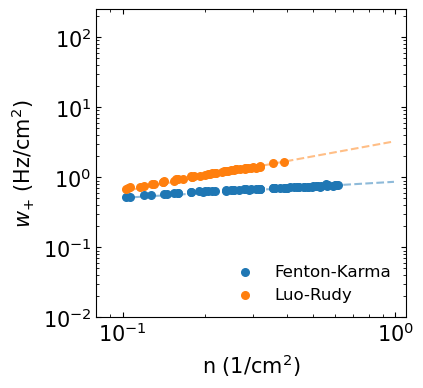

In [121]:
# fig,ax=plt.subplots()
# figsize = (6, 4)  #(5,4)
figsize = (4,4)
# fontsize=16
fig,ax=plt.subplots(figsize=figsize)
fontsize=15
# x1lim=[0.008, 11]
# x1lim=[0.08, 11]
# x2lim=[0.01, 250]
legend_alpha=1.0
minx=0.1
alpha=0.2
s=40
# fontsize=18
use_loglog=True
frameon_legend=False
show_fk=True
show_lr=True
zorder=0
# df_birth_fk.plot(x='q',y='w',ax=ax,c='C0',alpha=0.5,label=r'FK: N$\rightarrow$N+2',lw=4)
# fk.plot(x='q',y='w',ax=ax,c='C0',label=r'FK: N$\rightarrow$N-2',lw=4)
# df_birth_lr.plot(x='q',y='w',ax=ax,c='C1',alpha=0.5,label=r'LR: N$\rightarrow$N+2',lw=4)
# lr.plot(x='q',y='w',ax=ax,c='C1',label=r'LR: N$\rightarrow$N-2',lw=4)
markersize=30

# df_birth_fk.plot.scatter(x='q',y='w',ax=ax,c='C0',#'gray',#
df_birth_fk[df_birth_fk['q']>minx].plot.scatter(x='q',y='w',ax=ax,c='C0',#'gray',#
#                          marker='^',label=r'FK: N$\rightarrow$N+2',
                         label=r'Fenton-Karma',
                         alpha=1.,s=markersize)
# fk.plot.scatter(x='q',y='w',ax=ax,c='C0',label=r'FK: N$\rightarrow$N-2',s=markersize)
# df_birth_lr.plot.scatter(x='q',y='w',ax=ax,c='C1',#'r',#
df_birth_lr[df_birth_lr['q']>minx].plot.scatter(x='q',y='w',ax=ax,c='C1',#'r',#
#                         marker='^',label=r'LR: N$\rightarrow$N+2',
                         label=r'Luo-Rudy',
                         alpha=1.,s=markersize)
# lr.plot.scatter(x='q',y='w',ax=ax,c='C1',label=r'LR: N$\rightarrow$N-2',s=markersize)

#plot the powerlaw fits
# ax.plot(xv,yv_death_fk,'k--',alpha=0.5)
# ax.plot(xv,yv_death_lr,'k--',alpha=0.5)
# ax.plot(xv,yv_birth_fk,'k--',alpha=0.5)
# ax.plot(xv,yv_birth_lr,'k--',alpha=0.5)
ax.plot(xv,yv_birth_fk,'C0--',alpha=0.5)
ax.plot(xv,yv_birth_lr,'C1--',alpha=0.5)

# #draw vertical dotted line up to the intersection point for both of the full models
# ax.scatter([qstar_fk],[wstar_fk],c='k',s=40,alpha=0.9,zorder=100)
# ax.scatter([qstar_lr],[wstar_lr],c='k',s=40,alpha=0.9,zorder=100)
# ax.plot([qstar_fk,qstar_fk],[0.001,wstar_fk],'k:',alpha=0.9)
# ax.plot([qstar_lr,qstar_lr],[0.001,wstar_lr],'k:',alpha=0.9)

ax.tick_params(top=True, right=True,direction='in',which='both')
format_plot(ax=ax,xlabel=r'$n$ (1/cm$^2$)',ylabel=r'$w_-$ (Hz/cm$^2$)',fontsize=fontsize,use_loglog=True)
# format_plot(ax=ax,xlabel=r'$q$ (1/cm$^2$)',ylabel=r'$w_-$ (Hz/cm$^2$)',fontsize=fontsize,use_loglog=True)
# ax.legend(loc='upper left',fontsize=fontsize-2)
# ax.legend(loc='lower right',fontsize=fontsize-2.,frameon=False,ncol=2)
# leg = ax.legend(loc=(1.04,0.2),fontsize=fontsize-2.,frameon=False)
leg = ax.legend(loc='upper left',fontsize=fontsize-3.,frameon=False,ncol=1)
# leg = ax.legend(loc='lower right',fontsize=fontsize-3.,frameon=False,ncol=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

    
    
# format_plot
format_plot(ax=ax,xlabel=r'n (1/cm$^2$)',ylabel=r'$w_{+}$ (Hz/cm$^2$)',fontsize=fontsize)#,use_loglog=True)
# format_plot(ax=ax,xlabel=r'n (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize)#,use_loglog=True)
# format_plot(ax=ax,xlabel=r'q (1/cm$^2$)',ylabel=r'w (Hz/cm$^2$)',fontsize=fontsize)#,use_loglog=True)
# # plt.legend(fontsize=14,frameon=False,loc='upper left')
# plt.legend(fontsize=14,frameon=False,loc='upper left')
# # ax.get_legend().remove()


leg = ax.legend(loc='lower right',fontsize=fontsize-3.,frameon=False,ncol=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
# ax.get_legend().remove()

# AddLegend(loc='upper left')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim((0.0023641776732192935, 25.08908114695242))
ax.tick_params(top=True, right=True,direction='in',which='both')
# ax.set_xlim((0.008, 11.0))
# ax.set_ylim((0.01, 250.0))
# ax.set_xlim(x1lim)
ax.set_xlim([0.08, 1.1])
ax.set_ylim(x2lim)
plt.show()

In [122]:
x1lim

[0.08, 11]

## compute the exponents of the above powerlaw fits

In [123]:
# minN=8
minN=8
use_filterby_minN=True
print(f"{minN=}, {use_filterby_minN=}")

minN=8, use_filterby_minN=True


In [124]:
# Linear Particle (L=5)
df_fit_fk = dict_results_fk_lst[0]['df_fit'].copy()
dg_fit_fk = dict_results_fk_lst[0]['dg_fit'].copy()
df_fit_lr = dict_results_lr_lst[0]['df_fit'].copy()
dg_fit_lr = dict_results_lr_lst[0]['dg_fit'].copy()

if use_filterby_minN:
    df_fit_fk = df_fit_fk[df_fit_fk['N']>=minN].copy()
    df_fit_lr = df_fit_lr[df_fit_lr['N']>=minN].copy()

L=5
print(f"\nFK model ({L=}):")
print_fit_power_law(df_fit_fk['q'].values,df_fit_fk['w'].values)
print(f"\nLR model ({L=}):")
print_fit_power_law(df_fit_lr['q'].values,df_fit_lr['w'].values)

# Linear Particle (L=10)
df_fit_fk = dict_results_fk_lst[1]['df_fit'].copy()
dg_fit_fk = dict_results_fk_lst[1]['dg_fit'].copy()
df_fit_lr = dict_results_lr_lst[1]['df_fit'].copy()
dg_fit_lr = dict_results_lr_lst[1]['dg_fit'].copy()

if use_filterby_minN:
    df_fit_fk = df_fit_fk[df_fit_fk['N']>=minN].copy()
    df_fit_lr = df_fit_lr[df_fit_lr['N']>=minN].copy()

L=10
print(f"\nFK model ({L=}):")
print_fit_power_law(df_fit_fk['q'].values,df_fit_fk['w'].values)
print(f"\nLR model ({L=}):")
print_fit_power_law(df_fit_lr['q'].values,df_fit_lr['w'].values);


FK model (L=5):
m = 1.702548 +/- 0.014277
M = 4.922794 +/- 0.118524 Hz/cm^2; B=2.550199 +/- 0.015533
RMSE=0.6735 Hz/cm^2; R^2=0.9983; N=93

LR model (L=5):
m = 1.348083 +/- 0.014586
M = 13.713505 +/- 0.540855 Hz/cm^2; B=6.974772 +/- 0.053184
RMSE=1.7381 Hz/cm^2; R^2=0.9972; N=93

FK model (L=10):
m = 1.909806 +/- 0.023247
M = 5.386059 +/- 0.212294 Hz/cm^2; B=2.414923 +/- 0.022797
RMSE=0.1421 Hz/cm^2; R^2=0.9965; N=93

LR model (L=10):
m = 1.641404 +/- 0.033152
M = 14.090363 +/- 1.178961 Hz/cm^2; B=5.011447 +/- 0.081221
RMSE=0.6779 Hz/cm^2; R^2=0.9904; N=93


In [125]:
print(f"expected exponents for FK: 1.88 ± 0.03")

print(f"\nexpected exponents for LR: 1.638±0.017")

expected exponents for FK: 1.88 ± 0.03

expected exponents for LR: 1.638±0.017


compare to incumbent exponent row: <br>
$\nu_-:$ 1.638±0.017 1.613±0.014 1.62±0.03 1.88 ± 0.03 1.80±0.02 1.92±0.06

# Generation of figure 3
Tim Tyree<br>
1.3.2022

In [126]:
#TODO(later): remake these plots with any a,D,r,kappa combination inside the bounds of the result of my >500 years of computation time
#HINT: interp=recall_particle_model_interp()  #estimated run time ~20 seconds
# comp_mse_via_interp_unattractive
# import cudf

In [52]:
# #recall the fit of the particle model to the powerlaw fits from the full models
# wjr=recall_powerlaw_fits_to_full_models()
# print(*wjr)

In [53]:
# # recall_particle_parameter_fits 
# a,D,r,kappa,rmse=recall_particle_parameter_fits('luorudy')
# a,D,r,kappa,rmse=recall_particle_parameter_fits('fentonkarma')
# a_hat_FK, D_hat_FK, a_hat_FK_long, a_hat_FK_vlong, a_hat_LR, D_hat_LR, a_hat_LR_long=recall_particle_parameter_measurements()

# generate plot of powerlaw annihilation rates from the linear particle model
- DONE: directly compute the powerlaws from the particle model with vector-summed inverse powerlaw attraction
- Nota Bene: this process is automated by my pythonic function recall_particle_model_interp from lib

In [179]:
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_18_all_powerlaw_fits.csv"
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_17_all_powerlaw_fits.csv"
input_fn=f"{nb_dir}/data/osg_output/run_15_all_powerlaw_fits.csv" #works for many parameter settings (L=10)
df=pd.read_csv(input_fn)
df.head()

,m,Delta_m,M,Delta_M,Rsq,rmse,rmse_full,model_name_full,q_min,q_max,...,x0,L,force_code,neighbor,reflect,set_second,no_repulsion,no_attraction,dt,Dt
0,4.231491,0.160727,93.361321,36.833594,0.996631,0.523422,3.733662,lr_pbc,0.24,0.7,...,0,5,2,1,0,0,0,0,0.00001,0.00001
1,1.990970,0.063111,25.768610,4.887806,0.997652,0.268464,1.689743,lr_pbc,0.24,0.7,...,0,5,2,1,0,0,0,0,0.00001,0.00001
2,2.096149,0.062995,29.023787,5.132623,0.997889,0.201797,2.107838,lr_pbc,0.24,0.7,...,0,5,2,1,0,0,0,0,0.00001,0.00001
3,2.938888,0.073003,16.435418,2.756748,0.998556,0.101718,0.770270,fk_ncbc,0.24,0.7,...,0,5,2,1,0,0,0,0,0.00001,0.00001
4,2.353145,0.071580,7.303514,1.181615,0.997837,0.068909,0.134410,fk_pbc,0.24,0.7,...,0,5,2,1,0,0,0,0,0.00001,0.00001


In [12]:
r=0.1
kappa=500#250
D=0.7
# varkappa_lst=sorted(set(df['varkappa'].values))
# varkappa_lst

#TODO: extract xy values for kappa, r, D fixed to any value, which I can change later
#define constant parameters
reflect=0
force_code=2
set_second=0
neighbor=0
no_attraction=0
no_repulsion=0
# kappa=100
L=10

#template query for the DataFrame
query =(df.set_second==set_second)
query&=(df.no_repulsion==no_repulsion)&(df.no_attraction==no_attraction)
query&=(df.neighbor==neighbor)&(df.force_code==force_code)
query&=df.r==r
query&=df.kappa==kappa
query&=df.D==D
query&=df.L==L
# query&=df.x0==x0
query_template=query.copy()

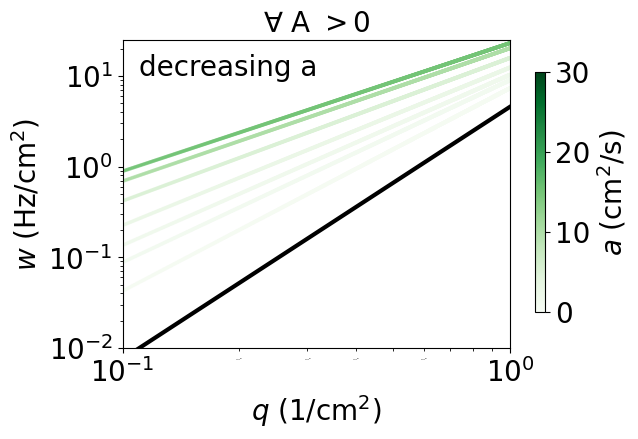

In [13]:
num_points = 25
c_col = 'rmse_full'
vmin = 0.
vmax = .25
fontsize = 20
x1lim = [1e-1, 1]
x2lim = [1e-2, 25]
# x1lim=[5,10]
# x2lim=[50,350]
fig, ax = plt.subplots(figsize=(5,4))
varkappa_lst = sorted(set(df['varkappa'].values))
varkappa_lst = list(reversed([0,1,2,3, 5, 10, 20, 30]))

vmin = 0
vmax = np.max(varkappa_lst)
for varkappa in varkappa_lst:
    #extract the data
    query = query_template.copy()
    query &= df.varkappa == varkappa
    M_returned = df.loc[query, 'M'].values
    nu_returned = df.loc[query, 'm'].values
    #     print((M_returned.shape,nu_returned.shape))  #shows there is a unique fit recalled
    M = M_returned[0]
    nu = nu_returned[0]
    x_values = np.linspace(0, 1, 1000)
    y_values = M * x_values**nu
    c_values = varkappa + 0. * x_values

    #scatter plot
    if varkappa==0:
        ax.plot(x_values,y_values,c='black',alpha=1.,lw=3)#,s=5)
        first_case=False
    else:
        ax.scatter(x_values,y_values,
               c=c_values,cmap='Greens',alpha=0.7,s=3,vmin=vmin,vmax=2*vmax)
# title=f'Top {num_points} Trials for {modelname} Model\n'
FormatAxes(ax,
           x1lim=x1lim,
           x2lim=x2lim,
           x1label=r'$q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
           x2label=r'$w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
           title=None,
           fontsize=fontsize,
           use_loglog=True)
# cbar=fig.colorbar(cmap='bone', ax=ax, shrink=0.6,label=r'RMSE$_{particle\;vs\;full}$')#, location='top'
# fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
#     cbar=fig.colorbar(pcm, ax=axs[:, col],shrink=0.6)#,label=output_col)

import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.Greens
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax,
                               cmap=cmap,
                               norm=norm,
                               spacing='proportional')
cb.set_label(r'$a$ (cm$^{2}/$s)', fontsize=fontsize)
cb.ax.tick_params(labelsize=fontsize)

ax.annotate("decreasing a", xy=(0.3, 11), xytext=(0.11, 10),fontsize=fontsize)
ax.set_title(r'$\forall $ A $ > 0$',fontsize=fontsize)
# ax.set_title(r'For all A $ > 0$',fontsize=fontsize)
plt.show()

__dependence of M on a__

src 'generate figure effect of increasing a.ipynb':
- for D=0.7, kappa=250, r=0.1 fixed,
- the powerlaw OLS fit for loglog of M versus a
- m=0.34662844685683697
- Delta_m=0.007544034420649642
- b=1.5430792099954873
- Delta_b=0.023831286783598894
- Rsquared=0.9972947153026107

#  DONE: generate Fig. 2C individually

In [134]:
#load birth death rates from the full model
data_folder=f'{nb_dir}/data'
os.chdir(data_folder)

data_fk_fn='full_results/data_fig4_vidmar_fk_tt.csv'
data_lr_fn='full_results/data_fig4_vidmar_lr_tt.csv'

fk=pd.read_csv(data_fk_fn)
fk['N']=fk['No2']*2
fk['q']=fk['N']/fk['A'] #number of tips per square centimeter
fk['w']=fk['rate']/fk['A']*10**3 #Hz/cm^2

lr=pd.read_csv(data_lr_fn)
lr['N']=lr['No2']*2
lr['q']=lr['N']/lr['A'] #number of tips per square centimeter
lr['w']=lr['rate']/lr['A']*10**3 #Hz/cm^2

In [135]:
#DONT: dev PlotScatter function for the full models
#input: ax, df=lr or fk, c='C0' or 'C1'
#output: True and plotted values
#reset matplotlib
mpl.rcParams.update(matplotlib.rcParamsDefault)


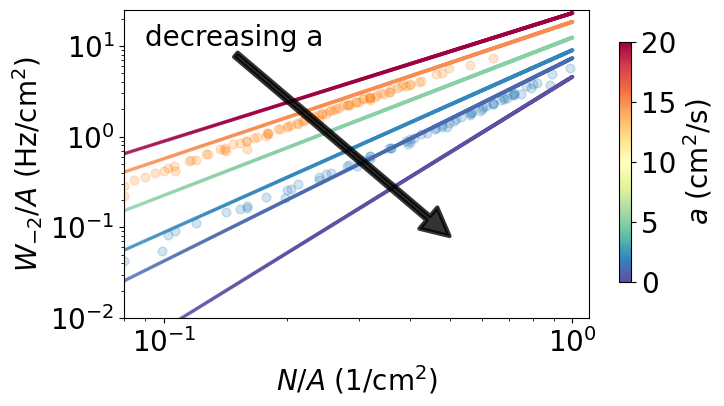

In [136]:
cmap = 'Spectral' + '_r'
num_points = 25
c_col = 'rmse_full'
fontsize = 20
xytext = (0.09, 10)
x1lim = [8e-2, 1.1]  #[1e-1, 1]
x2lim = [1e-2, 25]
# x1lim=[5,10]
# x2lim=[50,350]
figsize = (6, 4)  #(5,4)
fig, ax = plt.subplots(figsize=figsize)

# #plot the particle models
# varkappa_lst = sorted(set(df['varkappa'].values))
varkappa_lst = list(reversed([0, 1, 2, 5, 15, 30]))
# varkappa_lst = list(reversed([0,1,2,3, 5, 10, 20, 30]))

vmin = 0
vmax = 20  #np.max(varkappa_lst)
for varkappa in varkappa_lst:
    #extract the data
    query = query_template.copy()
    query &= df.varkappa == varkappa
    M_returned = df.loc[query, 'M'].values
    nu_returned = df.loc[query, 'm'].values
    #     print((M_returned.shape,nu_returned.shape))  #shows there is a unique fit recalled from cache
    M = M_returned[0]
    nu = nu_returned[0]
    x_values = np.linspace(0, 1, 1000)
    y_values = M * x_values**nu
    c_values = varkappa + 0. * x_values
    #plot
    ax.scatter(x_values,
               y_values,
               c=c_values,
               cmap=cmap,
               alpha=0.6,
               s=3,
               vmin=vmin,
               vmax=vmax)
# title=f'Top {num_points} Trials for {modelname} Model\n'
FormatAxes(
    ax,
    x1lim=x1lim,
    x2lim=x2lim,
    x1label=r'$N/A$ (1/cm$^{2}$)',  #q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
    x2label=
    r'$W_{-2}/A$ (Hz/cm$^{2}$)',  #w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
    title=None,
    fontsize=fontsize,
    use_loglog=True)
# cbar=fig.colorbar(cmap='bone', ax=ax, shrink=0.6,label=r'RMSE$_{particle\;vs\;full}$')#, location='top'
# fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
#     cbar=fig.colorbar(pcm, ax=axs[:, col],shrink=0.6)#,label=output_col)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap_obj = mpl.cm.get_cmap(cmap)
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax,
                               cmap=cmap_obj,
                               norm=norm,
                               spacing='proportional')
cb.set_label(r'$a$ (cm$^{2}/$s)', fontsize=fontsize)
cb.ax.tick_params(labelsize=fontsize)

#plot the full models
ax.scatter(fk['q'].values,
           fk['w'].values,
           c='C0',
           alpha=0.2,
           s=40,
           label='Fenton-Karma',
           zorder=0)
ax.scatter(lr['q'].values,
           lr['w'].values,
           c='C1',
           alpha=0.2,
           s=40,
           label='Luo-Rudy',
           zorder=0)

#plot arrow annotation
ax.annotate("decreasing a", xy=(0.3, 11), xytext=xytext, fontsize=fontsize)
ax.annotate(
    "",
    xy=(0.5, 0.08),
    xytext=(0.15, 8),  #,zorder=-1e8,#zorder can send to back
    arrowprops=dict(lw=3, headwidth=20., headlength=20., color='k',
                    alpha=0.8))  #arrowstyle="->",

#TODO: add dashed-black line below a=0 with slope of exactly two
# #TODO: mark the slope of ^that line with ~2
# x1 = 0.09
# y1 = 2
# annotation.slope_marker(origin=(x1, y1),
#                         slope=2,
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
#                         ax=ax)
# #DONE: mark the slope of ^that line with ~3
# x1 = 0.6
# y1 = 0.3
# annotation.slope_marker(origin=(x1, y1),
#                         slope=3,#(3, 1),
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
#                         ax=ax)

# # #DONE: test whether this slope is correct with a scatter plot of 2 points
# # x2 = 0.7
# # y2 = y1 * (x2 / x1)**3
# # ax.scatter([x1,x2],[y1,y2],marker='^',c='r',s=100,zorder=-1)
# # #DONT: if not, dev my own custom loglog slope plotter
# leg = ax.legend(loc='lower right', fontsize=fontsize - 6)
# for lh in leg.legendHandles:
#     lh.set_alpha(1)
plt.show()

In [137]:
print(f"Notes on Fig. 2")
print(f"kappa={kappa} Hz, r = {r} cm, D={D} cm^2/s, fixed.")
print(f"in order to make the particle model line up better with the FK model, I'll need to change r to 0.8 or 0.6 cm...")
print(f"^this would require a bit of coding, to use interp instead of df...")

Notes on Fig. 2
kappa=500.0 Hz, r = 0.1 cm, D=0.365 cm^2/s, fixed.
in order to make the particle model line up better with the FK model, I'll need to change r to 0.8 or 0.6 cm...
^this would require a bit of coding, to use interp instead of df...


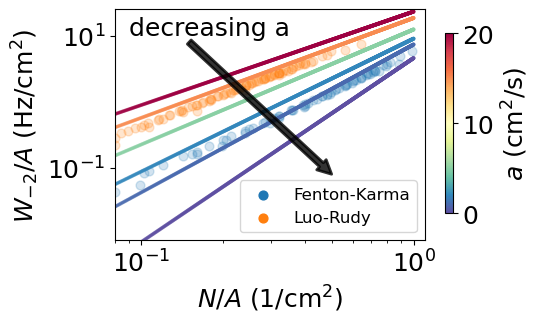

In [138]:
cmap='Spectral'+'_r'
num_points = 25
c_col = 'rmse_full'
fontsize = 18
xytext=(0.09, 10)
x1lim = [8e-2, 1.1]#[1e-1, 1]
x2lim = [8e-3, 25]
# x2lim = [4e-3, 25]
# x1lim=[5,10]
# x2lim=[50,350]
figsize=(4,3)#(5,4)
fig, ax = plt.subplots(figsize=figsize)

# #plot the particle models
# varkappa_lst = sorted(set(df['varkappa'].values))
varkappa_lst = list(reversed([0, 1, 2, 5, 15, 30]))
# varkappa_lst = list(reversed([0,1,2,3, 5, 10, 20, 30]))
vmin = 0
vmax = 20#np.max(varkappa_lst)
for varkappa in varkappa_lst:
    #extract the data
    query = query_template.copy()
    query &= df.varkappa == varkappa
    M_returned = df.loc[query, 'M'].values
    nu_returned = df.loc[query, 'm'].values
    #     print((M_returned.shape,nu_returned.shape))  #shows there is a unique fit recalled from cache
    M = M_returned[0]
    nu = nu_returned[0]
    x_values = np.linspace(0, 1, 1000)
    y_values = M * x_values**nu
    c_values = varkappa + 0. * x_values
    #plot 
    ax.scatter(x_values,y_values,
               c=c_values,cmap=cmap,alpha=0.6,s=3,vmin=vmin,vmax=vmax)
# title=f'Top {num_points} Trials for {modelname} Model\n'
FormatAxes(ax,
           x1lim=x1lim,
           x2lim=x2lim,
           x1label=r'$N/A$ (1/cm$^{2}$)',#q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
           x2label=r'$W_{-2}/A$ (Hz/cm$^{2}$)',#w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
           title=None,
           fontsize=fontsize,
           use_loglog=True)
# cbar=fig.colorbar(cmap='bone', ax=ax, shrink=0.6,label=r'RMSE$_{particle\;vs\;full}$')#, location='top'
# fig.colorbar(pcm, ax=[axs[0, col]], location='top', shrink=0.6)
#     cbar=fig.colorbar(pcm, ax=axs[:, col],shrink=0.6)#,label=output_col)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap_obj = mpl.cm.get_cmap(cmap)
cax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
cb = mpl.colorbar.ColorbarBase(cax,
                               cmap=cmap_obj,
                               norm=norm,
                               spacing='proportional')
cb.set_label(r'$a$ (cm$^{2}/$s)', fontsize=fontsize)
cb.ax.tick_params(labelsize=fontsize)

#plot the full models
ax.scatter(fk['q'].values,fk['w'].values,c='C0',alpha=0.2,s=40,label='Fenton-Karma',zorder=0)
ax.scatter(lr['q'].values,lr['w'].values,c='C1',alpha=0.2,s=40,label='Luo-Rudy',zorder=0)

#plot arrow annotation
ax.annotate("decreasing a", xy=(0.3, 11), xytext=xytext,fontsize=fontsize)
ax.annotate("", xy=(0.5, 0.08), xytext=(0.15, 8),#,zorder=-1e8,#zorder can send to back
            arrowprops=dict(lw=2,headwidth=10.,headlength=10.,color='k',alpha=0.8))#arrowstyle="->",

leg=ax.legend(loc='lower right',fontsize=fontsize-6)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
plt.show()
#TODO: lower fontsize in the yticksllabels only

In [139]:
# matplotlib.colors.get_named_colors_mapping()

In [140]:
#DONE(easy): plot the original full model annihilation rate measurements
#DONE: find previous "decreasing a" plot NOT from 'Generating Annihilation Rate Plots from Remote Cache of Particle Model.ipynb'
#TODO: merge ^those
#TODO: perform basic edits to match sketch

# DONE: generate Fig. 2A  individually
- for 2A as the best fits to the particle models (blue) FK and (orange) LR.
    - try showing loglog fit first
- for 2B as the residuals with (dashed) a=0 and (solid) a>0 for both of the full models?

In [181]:
# recall_particle_model_interp?

In [184]:
#recall results from tables in the main mansucript
wjr=recall_powerlaw_fits_to_full_models()

# input_fn=f"{nb_dir}/data/osg_output/run_15_all_powerlaw_fits.csv"
# input_fn=f"{nb_dir}/data/osg_output/run_17_all_powerlaw_fits.csv" #works for many (L=10)
# L=10
input_fn=f"{nb_dir}/data/osg_output/run_25_all_powerlaw_fits.csv" # (L=5)
L=5

input_fn_dict={'vectorsummed':input_fn,'neighboronly':input_fn}
interp=recall_particle_model_interp(input_fn_dict=input_fn_dict,L=L,mode='neighboronly')
# interp=recall_particle_model_interp(input_fn_dict=input_fn_dict)
a_hat_FK, D_hat_FK, a_hat_FK_long, a_hat_FK_vlong, a_hat_LR, D_hat_LR, a_hat_LR_long=recall_particle_parameter_measurements()

estimated runtime is ~20 seconds for 17988 training samples...
number of training examples is 17640....
training complete!


In [199]:
1

1

In [200]:
a_hat_FK, D_hat_FK, a_hat_FK_long, a_hat_FK_vlong, a_hat_LR, D_hat_LR, a_hat_LR_long=recall_particle_parameter_measurements()
# D_hat_FK=0
# D_hat_LR=0

# a_hat_LR=3.535902#-2*0.58 
# a_hat_LR=3.535902#-2*0.58 
# a_hat_LR_long=3.535902#-2*0.58 

# a_hat_FK=1.604153# - 2*0.365
# a_hat_FK_long=1.604153# - 2*0.365

D_hat_FK=0.365
D_hat_LR=0.58

In [201]:
# #FK 200x200, diffCoeff=0.001
# # src: TT
# alinear=1.12
# D=.365
# # src: wjr
# M=5.57# +/- (30)
# nu=1.877# +/- (25)
# L=5

# #didn't work...
# #LR 200x200, diffCoeff=0.0005
# # src: TT
# alinear=2.76 
# D=0.58
# # src: wjr
# M=16.73# +/- (84)
# nu=1.638# +/- (17)
# L=5

#TODO: fix interp_magnitude(x1,x2,x3,x4) to an observed value from the full model

# #FK 200x200, diffCoeff=0.0005, src: WJ
a=1.553
D=0.5
# D=0.114
# # M=2.7 # +/- (1.3) #hmean, my measurement
# # nu=0.84 # +/- (17)#hmean, my measurement
# L=5

# M=5.57#5.807  #   #hmean?, wj's measurement
# nu=1.877 #   #hmean?, wj's measurement

#LR 200x200, diffCoeff=0.001, src: WJ
# a=9.969
# D=0.09
# M=12.6 # +/- (3.8)  #hmean, my measurement
# nu=1.20 # +/- (8)   #hmean, my measurement
# L=5
# M=16.73#19.62  #   #hmean?, wj's measurement
# nu=1.638 #   #hmean?, wj's measurement

In [202]:
# #recall results from tables in the main mansucript..
# wjr=recall_powerlaw_fits_to_full_models()
# interp=recall_particle_model_interp()
# a_hat_FK, D_hat_FK, a_hat_FK_long, a_hat_FK_vlong, a_hat_LR, D_hat_LR, a_hat_LR_long=recall_particle_parameter_measurements()

In [203]:
#enter experimental attraction coefficients as substitute
# SMS:
# -  FK: ahat=1.65037
# MS:
# - FK: ahat=1.8876
#heretim

In [204]:
# #FK 200x200, diffCoeff=0.0005, src: WJ
a=1.553
#guessed
D=0.5

In [206]:
df.describe().T[['min','max']].T

,m,Delta_m,M,Delta_M,Rsq,rmse,rmse_full,q_min,q_max,r,...,x0,L,force_code,neighbor,reflect,set_second,no_repulsion,no_attraction,dt,Dt
min,1.373735,0.018717,1.607750,0.091699,0.987514,0.009421,0.088233,0.24,0.7,0.01,...,0.0,5.0,2.0,1.0,0.0,0.0,0.0,0.0,0.00001,0.00001
max,5.470393,0.375955,516.569239,610.191045,0.999933,3.628193,38.908264,0.24,0.7,0.49,...,0.0,5.0,2.0,1.0,0.0,0.0,0.0,0.0,0.00001,0.00001


In [207]:
0.7/4,2/4,

(0.175, 0.5)

In [208]:
# # ahat=1.8876  #rmse=0.04109107558241248 (FK)  # GammaBar with trivial trajectories
# ahat=1.65037#rmse=2.041284178317197e-08 (FK) # GammaBar without trivial trajectories
# a=ahat;
#,wjr=wjr,interp=interp,ax=ax,
# a=a_hat_FK_vlong;D=D_hat_FK#rmse=0.006797222653889483 (FK)
# a_hat_FK
# a=a_hat_FK;D=D_hat_FK #rmse=2.041284178317197e-08 (FK) #with ahat=1.65037

a=a_hat_FK;
D=D_hat_FK

In [209]:
# wjr['lr_pbc']
# a,D


In [210]:
model_name='fk_pbc'#;c='C0'
#compute annihilation rates fit to the LR model
nu_full=wjr[model_name]['m']
M_full=wjr[model_name]['M']
q_values=np.linspace(0,1,20)
w_values=M_full*q_values**nu_full
args=a,D,q_values,w_values,interp

if model_name=='lr_pbc':
    model_name_string='Luo-Rudy'
elif model_name=='fk_pbc':
    model_name_string='Fenton-Karma'
else:
    model_name_string='??'

#find a best r,kappa pair for a given a,D pair for a given full model
# args=a,D,q_values,w_values,interp
bnds = ((1e-3, 2), (1e2, 1e4))
x0 = (0.1, 500)
# res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
mse=comp_mse_via_interp(res.x, *args)
rmse=np.sqrt(mse)

#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
what_values=M*q_values**nu

q_values_fk=q_values.copy()
what_values_fk=what_values.copy()
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse} (FK) ")
dict_fk=dict(r=r,kappa=kappa,nu=nu,M=M,rmse=rmse,res=res)

a=1.65037, D=0.365, r=0.1, kappa=500.0, rmse=nan (FK) 


In [211]:
#enter experimental attraction coefficients as substitute

# TODO: test powerlaw fits of linear particle model for
# SMS:
# -  LR: ahat=9.60637,7.28148
# -  FK: ahat=1.65037
# MS:
# - LR: ahat=7.13454,4.99485
# - FK: ahat=1.8876
#heretim
# L

In [218]:
#200x200, diffCO0ff=0.0005, (FK) (src: WJ)
a=1.553  
D=.114

# #200x200, diffCO0ff=0.001, (FK) (src: TT)
# a=1.12  *4
# D=.365   *4

model_name='fk_pbc'#;c='C0'
#compute annihilation rates fit to the LR model
nu_full=wjr[model_name]['m']
M_full=wjr[model_name]['M']



q_values=np.linspace(0,1,20)
w_values=M_full*q_values**nu_full
args=a,D,q_values,w_values,interp

if model_name=='lr_pbc':
    model_name_string='Luo-Rudy'
elif model_name=='fk_pbc':
    model_name_string='Fenton-Karma'
else:
    model_name_string='??'

#find a best r,kappa pair for a given a,D pair for a given full model
# args=a,D,q_values,w_values,interp
bnds = ((1e-3, 2), (1e2, 1e4))
x0 = (0.1, 500)
# res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
mse=comp_mse_via_interp(res.x, *args)
rmse=np.sqrt(mse)

#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
# M=M_full
# nu=nu_full
what_values=M*q_values**nu

q_values_fk=q_values.copy()
what_values_fk=what_values.copy()
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse} (FK) fit to {M=}, {nu=}")
dict_fk=dict(r=r,kappa=kappa,nu=nu,M=M,rmse=rmse,res=res)

a=1.553, D=0.114, r=0.017781397592813993, kappa=579.99890233808, rmse=0.17419668083508041 (FK) fit to M=5.829048139230627, nu=2.209161916893618


In [219]:
# #victor for LR: SMS with GammaBar computed from the average of all spiral tip observations
# # SMS:a=9.60637, D=0.586055, r=0.11865725394705823, kappa=453.30813258922205, rmse=0.031175747845115034 (LR)
# ahat=9.60637#rmse=0.031175747845115034 (LR)
# # ahat=7.28148 #rmse=0.16022186827576143 (LR)
# # MS:
# # ahat=4.99485 # rmse=0.4555348657752726 (LR)
# # ahat=7.13454# rmse=0.17979087126721505 (LR)
# a=ahat;
# a=a_hat_LR
# D=D_hat_LR     #^those

# LR 200x200, diffCoeff=0.001 (src: WJ)
a=9.969
D=0.09     
# a=9.969    *4
# D=0.09     *4

# # #LR 200x200, diffCoeff=0.0005 (src: WJ)
# a=2.767   
# D=0.58    

# a=a_hat_LR;D=D_hat_LR #rmse=0.028075538795257697 (LR)
model_name='lr_pbc'#;c='C1'
#compute annihilation rates fit to the LR model
nu_full=wjr[model_name]['m']
M_full=wjr[model_name]['M']
q_values=np.linspace(0,1,20)
w_values=M_full*q_values**nu_full

if model_name=='lr_pbc':
    model_name_string='Luo-Rudy'
elif model_name=='fk_pbc':
    model_name_string='Fenton-Karma'
else:
    model_name_string='??'

#find a best r,kappa pair for a given a,D pair for a given full model
args=a,D,q_values,w_values,interp
bnds = ((1e-3, 2), (1e2, 1e4))
x0 = (0.1, 500)
# res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
mse=comp_mse_via_interp(res.x, *args)
rmse=np.sqrt(mse)

#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
# M=M_full
# nu=nu_full

what_values=M*q_values**nu

q_values_lr=q_values.copy()
what_values_lr=what_values.copy()
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse} (LR) fit to {M=}, {nu=}")
dict_lr=dict(r=r,kappa=kappa,nu=nu,M=M,rmse=rmse,res=res)

a=9.969, D=0.09, r=0.10167659656211231, kappa=331.6765983125879, rmse=0.26662884058494135 (LR) fit to M=17.11419949285171, nu=1.777195613756067


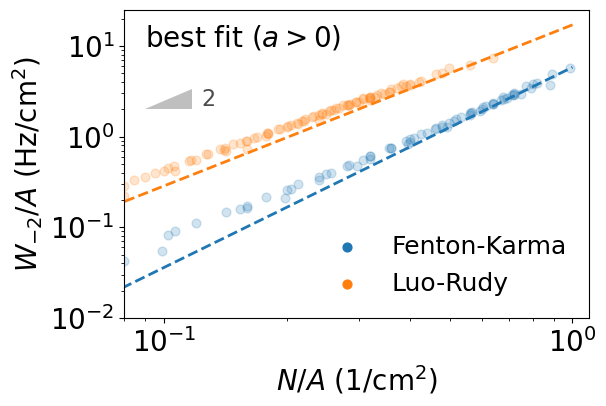

(9.969, 17.11419949285171, 1.777195613756067)

In [217]:
#plot the best fits when a>0
fontsize = 20
x1lim = [8e-2, 1.1]  #[1e-1, 1]
x2lim = [1e-2, 25]
xytext=(0.09, 10)
# x1lim=[5,10]
# x2lim=[50,350]
figsize = (6, 4)  #(5,4)
fig, ax = plt.subplots(figsize=figsize)

#plot the full models
ax.scatter(fk['q'].values,fk['w'].values,c='C0',alpha=0.2,s=40,label='Fenton-Karma',zorder=0)
ax.scatter(lr['q'].values,lr['w'].values,c='C1',alpha=0.2,s=40,label='Luo-Rudy',zorder=0)

#plot the result over the original annihilation rates
plt.plot(q_values_fk,what_values_fk,'--',c='C0',label=f'_Fit to FK',alpha=1,lw=2)
plt.plot(q_values_lr,what_values_lr,'--',c='C1',label=f'_Fit to LR',alpha=1,lw=2)

#format
FormatAxes(
    ax,
    x1lim=x1lim,
    x2lim=x2lim,
    x1label=r'$N/A$ (1/cm$^{2}$)',  #q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
    x2label=
    r'$W_{-2}/A$ (Hz/cm$^{2}$)',  #w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
    title=None,
    fontsize=fontsize,
    use_loglog=True)
ax.annotate(r"best fit ($a>0$)", xy=(0.3, 11), xytext=xytext,fontsize=fontsize)
leg=ax.legend(loc='lower right',fontsize=fontsize-2,frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
# #mark the slope of ^that line with ~2
# x1 = 0.2
# y1 = 2
# annotation.slope_marker(origin=(x1, y1),
#                         slope=2,invert=True,
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
#                         ax=ax)    
#mark the slope of ^that line with ~2
x1 = 0.09
y1 = 2
annotation.slope_marker(origin=(x1, y1),
                        slope=2,
                        text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
                        poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
                        ax=ax)
# #mark the slope of ^that line with ~3
# x1 = 0.6
# y1 = 0.3
# annotation.slope_marker(origin=(x1, y1),
#                         slope=3,#(3, 1),
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
#                         ax=ax)

plt.show()
# print(dict_fk)
# print(dict_lr)
a,M,nu

- a=1.604153, D=0.365, r=0.06044253208765449, kappa=495.47000078959877, rmse=0.006804554125240232 (FK)
- a=3.535902, D=0.58, r=0.135119007149973, kappa=599.9999001383585, rmse=0.77344154837527         (LR)

- a=1.65037, D=0.365, r=0.05782595089352863, kappa=514.0315155197962,  rmse=2.4886791584465667e-08 (FK)
- a=2.375902, D=0.58, r=0.1628483139602805,  kappa=462.41046982400314, rmse=1.0819217469564617     (LR)

In [96]:
1.604153 - 2*0.365 #FK

0.874153

In [51]:
3.535902-2*0.58 #LR

2.375902

# DONE: generate powerlaw fits directly from observed mean collision time 

In [23]:
input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_20_all/job.out.21377943.2385"
# input_fn="/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_19_all/job.out.19842066.24"
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_18_all/job.out.16106771.17"
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_17_all/job.out.15270959.1"
# input_fn=f"/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/black_star_run_1_all/out.0"
# input_fn="/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_16_all/job.out.14688026.14"
# input_fn="/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_15_all/job.out.13954413.14"
printing=True
npartitions=os.cpu_count()
# kwargs={}
kwargs=dict(npartitions=npartitions)
save_dir=gener_df_powerlaw_fits_and_to_csv(input_fn,**kwargs)

testing input_fn
{'m': 2.348691687055711, 'Delta_m': 0.01579402321139273, 'M': 8.45369889951118, 'Delta_M': 0.285922297679015, 'Rsq': 0.99897695178761, 'rmse': 0.15705548701034783, 'rmse_full': 0.43658535881740856, 'model_name_full': 'fk_ncbc', 'q_min': 0.1, 'q_max': 1.0, 'r': 0.07, 'kappa': 1500, 'D': 6.6, 'varkappa': 0, 'x0': 0, 'L': 10, 'force_code': 2, 'neighbor': 1, 'reflect': 0, 'set_second': 0, 'no_repulsion': 0, 'no_attraction': 0, 'dt': 1e-05, 'Dt': 1e-05}
parsing absolute directory of input_fn=/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_20_all/job.out.21377943.2385...
We're about to use 12 cores to obliterate 4018 csv files from /home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_20_all
run time for computing powerlaw fits was 20.78 seconds.
computed powerlaw fits for  4017 trials successfully.
parsing absolute directory of input_fn=/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_20_all/job.out.21377943.2385...
power

# DONE: generate Fig. 2B individually
- for 2B as the best fits to the particle models (blue) FK and (orange) LR when a=0
- for 2B as the residuals with (dashed) a=0 and (solid) a>0 for both of the full models?

In [24]:
#is a=2D in the annihilation rate fits? no.

In [25]:
for run_num in range(21):
    input_fn= f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all_powerlaw_fits.csv"
    try:
        df=pd.read_csv(input_fn)
        print(f"run #{run_num}: {df[df['varkappa']==0].shape}")
    except Exception as e:
        pass

run #5: (3242, 22)
run #6: (181944, 24)
run #15: (382, 22)
run #16: (0, 22)
run #17: (0, 22)
run #18: (0, 22)
run #19: (0, 22)
run #20: (4017, 24)


In [26]:
#DONE: see here if any df from pd.read_csv(input_fn) has powerlaws for the a=0 case
#DONE: try a bunch of run_num
# run_num=5 # uses the 'beta' column to show funny reaction rates/ranges didn't work
run_num=6
# run_num=15 #worked (N=186)
# run_num=20 #worked? (N=?) Enot really working#4017
# run_num=15#382
input_fn= f"/home/timothytyree/Documents/GitHub/bgmc/python/data/osg_output/run_{run_num}_all_powerlaw_fits.csv"
input_fn_dict={'vectorsummed':input_fn,'neighboronly':input_fn}

#recall results from tables in the main mansucript
wjr=recall_powerlaw_fits_to_full_models()
a_hat_FK, D_hat_FK, a_hat_FK_long, a_hat_FK_vlong, a_hat_LR, D_hat_LR, a_hat_LR_long=recall_particle_parameter_measurements()

df=pd.read_csv(input_fn)
print(f"varkappa values: {np.unique(df['varkappa'].values)}")
df.shape

varkappa values: [0]


(181944, 24)

In [27]:
#DONE: root cause analysis on why broken: recall_particle_model_interp_unattractive. answer mode='neighboronly' for run 20...
interp_unattractive=recall_particle_model_interp_unattractive(input_fn_dict=input_fn_dict,#mode='neighboronly',
                                                              printing=True,testing=True)#,L=None)

estimated runtime is ~140 seconds for 17988 training samples...
number of training examples is 1687....
training complete!
shape of X (1687, 3) --> shape of y=yhat (1687, 2)
Example Usage:
yhat=interp(X)
the rmse of simple interpolation is 0.0000


In [28]:
# #recall fits from lib
# # a,D,r,kappa,rmse=recall_particle_parameter_fits('luorudy')
# # print(f"a={a},    D={D}, r={r}, kappa={kappa},  rmse={rmse}")
# a,D,r,kappa,rmse=recall_particle_parameter_fits('fentonkarma')
# # print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")

# D=D_hat_FK
# kappa=500
# r=0.3#needed because the smaller r values havent' finished yet...
# a=0

In [29]:
#TODO: try dev function from ['r','kappa','D'] to mse, as before
#TODO: modify old routine for multidimensional optimization to here
#TODO: generate fig. 2B
#TODO: update drive
#TODO: see if a particle fit works when a=2D
# np.min(X[:,0]),np.max(X[:,0])

In [30]:
model_name='fk_pbc'
D=D_hat_FK
kappa=500
r=0.3#needed because the smaller r values havent' finished yet...
a=0

#compute annihilation rates fit to the LR model
nu_full=wjr[model_name]['m']
M_full=wjr[model_name]['M']
q_values=np.linspace(0,1,20)
w_values=M_full*q_values**nu_full
args=q_values,w_values,interp_unattractive

if model_name=='lr_pbc':
    model_name_string='Luo-Rudy'
elif model_name=='fk_pbc':
    model_name_string='Fenton-Karma'
else:
    model_name_string='??'

#find a best r,kappa pair for a given a,D pair for a given full model
# args=a,D,q_values,w_values,interp
bnds = ((0.01, 0.5), (250, 1500),(0.1,8.))
# bnds = ((0.3, 0.5), (250, 1500),(0.1,8.))
# x0 = (r,kappa,D)
x0 = (0.3,kappa,D)

res = minimize(comp_mse_via_interp_unattractive, x0, args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
mse=comp_mse_via_interp_unattractive(res.x, *args)
rmse=np.sqrt(mse)

#compute the resulting annihilation rates
a=0
r=res.x[0]
kappa=res.x[1]
D=res.x[2]
X=np.array([r,kappa,D])
yhat = interp_unattractive(X)
nu=yhat[0,0]
M=yhat[0,1]
what_values=M*q_values**nu

q_values_fk=q_values.copy()
what_values_fk=what_values.copy()
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse} (FK)")
dict_fk_unattractive=dict(r=r,kappa=kappa,nu=nu,M=M,rmse=rmse,res=res)

a=0, D=4.998975853600221, r=0.12254632061727341, kappa=250.0, rmse=0.14588114790017753 (FK)


In [31]:
# X=np.array([r,kappa,D])
# yhat = interp_unattractive(X)

In [32]:
model_name='lr_pbc'
# D=D_hat_LR
D=5
kappa=500
r=0.15#needed because the smaller r values havent' finished yet...
a=0

#compute annihilation rates fit to the LR model
nu_full=wjr[model_name]['m']
M_full=wjr[model_name]['M']
q_values=np.linspace(0,1,20)
w_values=M_full*q_values**nu_full
args=q_values,w_values,interp_unattractive

if model_name=='lr_pbc':
    model_name_string='Luo-Rudy'
elif model_name=='fk_pbc':
    model_name_string='Fenton-Karma'
else:
    model_name_string='??'

#find a best r,kappa pair for a given a,D pair for a given full model
# args=a,D,q_values,w_values,interp
bnds = ((0.01, 0.5), (250, 1500),(0.1,8.))
# bnds = ((0.3, 0.5), (250, 1500),(0.1,8.))
# x0 = (r,kappa,D)
x0 = (0.3,kappa,D)

res = minimize(comp_mse_via_interp_unattractive, x0, args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
mse=comp_mse_via_interp_unattractive(res.x, *args)
rmse=np.sqrt(mse)

# #compute the resulting annihilation rates
# a=0
# r=res.x[0]
# kappa=res.x[1]
# X=np.array([[r,kappa,D]])
# yhat = interp(X)
# nu=yhat[0,0]
# M=yhat[0,1]
# what_values=M*q_values**nu

# q_values_fk=q_values.copy()
# what_values_fk=what_values.copy()
# print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse} (FK)")
# dict_fk_unattractive=dict(r=r,kappa=kappa,nu=nu,M=M,rmse=rmse,res=res)


#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]#*1.7
D=res.x[2]
X=np.array([r,kappa,D])
yhat = interp_unattractive(X)
nu=yhat[0,0]
M=yhat[0,1]
what_values=M*q_values**nu

q_values_lr=q_values.copy()
what_values_lr=what_values.copy()
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse} (LR)")
dict_lr_unattractive=dict(r=r,kappa=kappa,nu=nu,M=M,rmse=rmse,res=res)

a=0, D=5.0, r=0.3, kappa=500.0, rmse=20.731065688766602 (LR)


In [33]:
#DONE: simplify ^that
#DONE: repeat ^that for LR
#TODO: generate plot
#TODO: update!

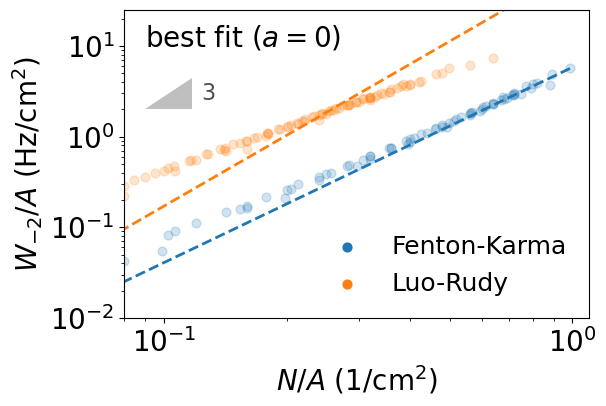

In [34]:
#plot the best fits when a>0
fontsize = 20
x1lim = [8e-2, 1.1]  #[1e-1, 1]
x2lim = [1e-2, 25]
# x1lim=[5,10]
# x2lim=[50,350]
figsize = (6, 4)  #(5,4)
fig, ax = plt.subplots(figsize=figsize)

#plot the full models
ax.scatter(fk['q'].values,fk['w'].values,c='C0',alpha=0.2,s=40,label='Fenton-Karma',zorder=0)
ax.scatter(lr['q'].values,lr['w'].values,c='C1',alpha=0.2,s=40,label='Luo-Rudy',zorder=0)

#plot the result over the original annihilation rates
plt.plot(q_values_fk,what_values_fk,'--',c='C0',label=f'_Fit to FK',alpha=1,lw=2)
plt.plot(q_values_lr,what_values_lr,'--',c='C1',label=f'_Fit to LR',alpha=1,lw=2)

#format
FormatAxes(
    ax,
    x1lim=x1lim,
    x2lim=x2lim,
    x1label=r'$N/A$ (1/cm$^{2}$)',  #q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
    x2label=
    r'$W_{-2}/A$ (Hz/cm$^{2}$)',  #w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
    title=None,
    fontsize=fontsize,
    use_loglog=True)
ax.annotate(r"best fit ($a=0$)", xy=(0.3, 11), xytext=xytext,fontsize=fontsize)
leg=ax.legend(loc='lower right',fontsize=fontsize-2,frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
# #mark the slope of ^that line with ~2
x1 = 0.09
y1 = 2
# annotation.slope_marker(origin=(x1, y1),
#                         slope=2,
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
#                         ax=ax)
#mark the slope of ^that line with ~3
# x1 = 0.6
# y1 = 0.3
annotation.slope_marker(origin=(x1, y1),
                        slope=3,#(3, 1),
                        text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
                        poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
                        ax=ax)

plt.show()

# DONE: Plot MSD for the full models

In [234]:
#options for FK
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/bootstrapped_msd_time_bins_auto.csv"
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/bootstrapped_msd_particle_bins_auto.csv"
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/bootstrapped_msd_particle_bins_30.csv"
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/bootstrapped_msd_particle_bins_auto.csv"
df=pd.read_csv(input_fn)
x_col='lagt_sec'
y_col='msd_cm2'#,ax=ax,c='C0',lw=2,label='Fenton-Karma')
yerr_col='Delta_msd_cm2'
yhat_col='hat_msd_cm2'
x_values_FK=df[x_col].values
y_values_FK=df[y_col].values
yerr_values_FK=df[yerr_col].values
yhat_values_FK=df[yhat_col].values

In [235]:
#options for LR
#options for LR
folder_lr="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5"
# folder_lr="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/ds_5_param_qu_tmax_30_Ko_5.4_diffCoef_0.001"
os.chdir(folder_lr)
# bootstrapped_msd_particle_bins_30.csv
# bootstrapped_msd_particle_bins_auto.csv
# bootstrapped_msd_time_bins_30.csv
# input_fn="bootstrapped_msd_time_bins_30.csv"
# input_fn="bootstrapped_msd_particle_bins_auto.csv"
input_fn="bootstrapped_msd_particle_bins_30.csv"
df=pd.read_csv(input_fn)
x_col='lagt_sec'
y_col='msd_cm2'#,ax=ax,c='C0',lw=2,label='Fenton-Karma')
yerr_col='Delta_msd_cm2'
yhat_col='hat_msd_cm2'
x_values_LR=df[x_col].values
y_values_LR=df[y_col].values
yerr_values_LR=df[yerr_col].values
yhat_values_LR=df[yhat_col].values

In [236]:
#fit to FK
tmin=.5#s
tmax=2#s
x_values=x_values_FK.copy()
y_values=y_values_FK.copy()
boo=(x_values>=tmin)&(x_values<tmax) #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/2
Delta_a_SR=dict_a_SR['Delta_m']/2
print(f"D_hat_FK = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmin={tmin}, tmax={tmax} (FK)")
a_hat_FK=a_SR
dict_fit_FK=dict_a_SR

#fit to LR
# tmin=.15#s
# tmax=.4#s
tmin=.1#s
tmax=.4#s
x_values=x_values_LR.copy()
y_values=y_values_LR.copy()
boo=(x_values>=tmin)&(x_values<tmax) #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/2
Delta_a_SR=dict_a_SR['Delta_m']/2
print(f"D_hat_LR = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmin={tmin}, tmax={tmax} (LR)")
a_hat_LR=a_SR
dict_fit_LR=dict_a_SR

D_hat_FK = 0.784341+/-0.008310 cm^2/s, tmin=0.5, tmax=2 (FK)
D_hat_LR = 0.768186+/-0.322757 cm^2/s, tmin=0.1, tmax=0.4 (LR)


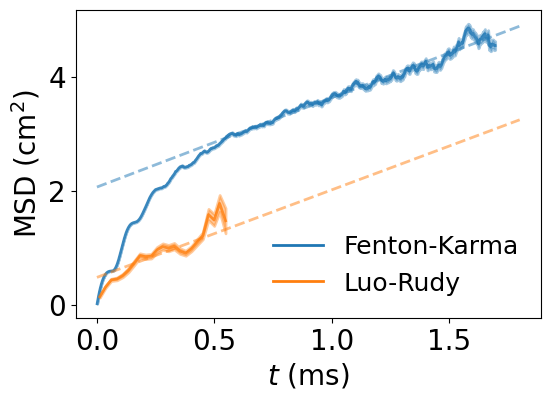

In [237]:
#plot the best fits when a>0
fontsize = 20
x1lim = [8e-2, 1.1]  #[1e-1, 1]
x2lim = [1e-2, 25]
# x1lim=[5,10]
# x2lim=[50,350]
figsize = (6, 4)  #(5,4)
fig,ax=plt.subplots(figsize=figsize)
#plot data
plt.plot(x_values_FK,y_values_FK,lw=2,alpha=0.8,c='C0',label='Fenton-Karma')
plt.fill_between(x_values_FK,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
plt.plot(x_values_LR,y_values_LR,lw=2,alpha=0.8,c='C1',label='Luo-Rudy')
plt.fill_between(x_values_LR,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
#plot fits

yhat_values_FK
xv=np.linspace(0,1.8,100)
yhat_values_FK=dict_fit_FK['m']*xv+dict_fit_FK['b']
yhat_values_LR=dict_fit_LR['m']*xv+dict_fit_LR['b']
plt.plot(xv,yhat_values_FK,'--',lw=2,alpha=0.5,c='C0')#,label='Fenton-Karma')
plt.plot(xv,yhat_values_LR,'--',lw=2,alpha=0.5,c='C1')#,label='Fenton-Karma')


#format plot
format_plot(ax=plt.gca(),xlabel=r'$t$ (ms)',ylabel=r'MSD (cm$^2$)',fontsize=fontsize)
leg=ax.legend(loc='lower right',fontsize=fontsize-2,frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
# plt.ylim([0,3.1])
plt.show()

In [ ]:
#other files to try to represent LR model
# bootstrapped_msd_particle_bins_30.csv
# bootstrapped_msd_particle_bins_auto.csv
# bootstrapped_msd_time_bins_30.csv
# creations
# creations_minr_1.0_mindur_20.0.csv
# ensemble_msd_particle_bins_30_minlifetime_300.0_cropstartby_0_cropendby_150.csv
# ensemble_msd_particle_bins_auto_minlifetime_150.0_cropstartby_0_cropendby_150.csv
# ensemble_msd_particle_bins_auto_minlifetime_300.0_cropstartby_0_cropendby_150.csv
# ensemble_msd_time_bins_30_minlifetime_300.0_cropstartby_0_cropendby_150.csv
# fig
# Log
# msd
# msd_particle_minlifetime_150.0_cropstartby_0_cropendby_150.csv
# msd_particle_minlifetime_300.0_cropstartby_0_cropendby_150.csv
# msd_time_minlifetime_300.0_cropstartby_0_cropendby_150.csv


# scratchwerk

In [ ]:
#Option 1: find the exact MSD plots I made before
#Option 2: compute MSD from the following:

In [138]:
# # file=search_for_file()
# file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/all_traj_longer_than_1000.csv'

T_min=1000#ms
omit_time=150#ms
DS=0.025#cm/pixel
figsize=(17,4);fontsize=16
saving=False

# df=pd.read_csv(file)
# DT=compute_time_between_frames(df);print(f"DT={DT}")

# df=return_unwrapped_trajectory(df, width, height, sr, mem, dsdpixel, **kwargs)
# df=get_all_longer_than(df,DT,T_min=T_min)

# #count remaining individuals
# num_individuals=len(list(set(df.particle.values)));print(f"num_individuals={num_individuals}")
# emsd=compute_emsd(traj=df.copy(), DT=DT, omit_time=omit_time, printing=False,DS=DS)


# #save emsd
# savefn=f"emsd_longer_than_{T_min}.csv"
# os.chdir(savefig_folder)
# emsd.to_csv(savefn)#,index=False)
# os.path.abspath(savefn)
# # emsd

file='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/archived_msd/emsd_longer_than_1000.csv'
DT=0.4
num_individuals=4064
emsd=pd.read_csv(file,index_col='lagt')
# lag_values,slope_values=compute_slope_vs_lag(emsd,T_min,omit_time,window_width=50,stepsize=10)

savefig_folder=os.path.dirname(file)#os.path.join(nb_dir,'Figures/msd_loglog')
savefig_fn=os.path.basename(file).replace('.csv','.png')#f'logMSD_vs_loglag_Tmin_{T_min/10**3:.1f}_N_{trials_considered}_mni_{min_num_individuals}.png'


fig,axs=plt.subplots(ncols=3,figsize=figsize)
plot_emsd(axs[0],emsd,label='_Hidden', color='black',alpha=1.)
format_plot_emsd(axs[0],use_loglog=False,fontsize=fontsize)

plot_emsd(axs[1],emsd,label='_Hidden', color='black',alpha=1.)
format_plot_emsd(axs[1],use_loglog=True,fontsize=fontsize)

lag_values,slope_values=compute_slope_vs_lag(emsd,T_min,omit_time,window_width=500,stepsize=10)
plot_slope_of_emsd(axs[2],lag_values,slope_values,label='_Hidden', color='black', alpha=1.,plot_reference_lines=True)

format_slope_of_emsd(axs[2],fontsize=fontsize,use_loglog=False)

if not saving:
    plt.tight_layout()
    plt.show()
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

#compute and print v_rms and D
# compute diffusion coefficient and rms velocity of spiral tips
v_rms,Delta_v_rms,_,_,Rsquared_v,_=compute_v_rms(emsd,num_points=8)
Dhat,Delta_Dhat,tau_min,tau_max,Rsquared_D,delta_tau=compute_Dhat(emsd,tau_min=300,window_width=500)

# Dhat,Delta_Dhat,tau_min,tau_max,Rsquared_D,delta_tau=compute_Dhat(emsd,tau_min=200,MSD_thresh=.2,max_lagtime=50)
print(f"make sure the right DT scale was used!")
print(f"make sure to record in spreadsheet!")
print(f"time window for D was from {tau_min:.0f} to {tau_max:.0f} ms.")
print(f"D = {Dhat} +- {Delta_Dhat} cm^2/s... Rsq={Rsquared_D}")
print(f"v_rms = {v_rms} +- {Delta_v_rms} cm/s... Rsq={Rsquared_v}")


#make pd.DataFrame that can be copy/pasted to a spreadsheet
df_output=pd.DataFrame({
    'exponent_final':slope_values[-1],
    'exponent_500':slope_values[lag_values==.5][0],
    "Dhat":[Dhat],
    "Delta_Dhat":[Delta_Dhat],
    "Rsquared_D":[Rsquared_D],
    "v_rms":v_rms,
    "Delta_v_rms":Delta_v_rms,
    "Rsquared_v":Rsquared_v,
    "num_individuals":num_individuals,
    "diffCoef":0.0005,
    'area':25,
    'model':'param_set_8'
})
print(num_individuals)
df_output

NameError: name 'plot_emsd' is not defined

## scratchwerk

In [136]:
compute_each_mean_squared_displacement_particle

NameError: name 'compute_each_mean_squared_displacement_particle' is not defined

In [134]:
# LR results for DT = 0.5 ms
modelname='luo-rudy'
# annihilations aggregated
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/annihilations_minr_1.0_mindur_20.0.csv"
# # # #creations aggregated
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/creations_minr_1.0_mindur_20.0.csv"
df_lr=pd.read_csv(input_fn)

# #LR results for DT = 0.025 ms
# #annihilations aggregated
# # input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.025/annihilations_minr_1.0_mindur_20.0.csv'
# # # #creations aggregated
# input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.025/creations_minr_1.0_mindur_20.0.csv'

# df_lr=pd.read_csv(input_fn)
# #FK results for DT = 0.4 ms
# #annihilations aggregated
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/annihilations_minr_1.0_mindur_20.0.csv"
# #creations aggregated
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/creations_minr_1.0_mindur_20.0.csv"
df_fk=pd.read_csv(input_fn)

df_fk.sort_values('tbirth',ascending=True,inplace=True)
df_lr.sort_values('tbirth',ascending=True,inplace=True)

# print(f"number of trials is {len(sorted(set(df_lr.pid.values)))} (LR) and {len(sorted(set(df_fk.pid.values)))} (FK).")

#compute xy values
x_label='time (ms)'#'t'
# x_label='time after annihilation (ms)'#'t'
y_label='inward/outward\nangle (radians)'#'$\vartheta$'
# 'r (cm)'
# 'dr/dt (cm/ms)'

df_phases=df_lr.copy()
t_values=sorted(set(df_phases.tbirth.values))
DT=sorted(set(df_phases.tbirth.values))[0]
#compute/plot average over particles
N=len(list(set(df_phases.pid.values)))
dfm=df_phases.groupby('tbirth').mean()
dfs=df_phases.groupby('tbirth').std()
# dfm=df_phases.groupby('tdeath').mean()
# dfs=df_phases.groupby('tdeath').std()
x_values_lr=dfm.index.values
y_values_lr=dfm.theta.values
yerr_values_lr=dfs.theta.values

df_phases=df_fk.copy()
t_values=sorted(set(df_phases.tbirth.values))
DT=sorted(set(df_phases.tbirth.values))[0]
#compute/plot average over particles
N=len(list(set(df_phases.pid.values)))
dfm=df_phases.groupby('tbirth').mean()
dfs=df_phases.groupby('tbirth').std()
# dfm=df_phases.groupby('tdeath').mean()
# dfs=df_phases.groupby('tdeath').std()
x_values_fk=dfm.index.values
y_values_fk=dfm.theta.values
yerr_values_fk=dfs.theta.values

In [135]:
dfm.head()

,pid,pid_birthmate,r,theta
tbirth,,,,
0.4,196.076023,195.935545,0.249673,3.017857
0.8,196.076023,195.935545,0.301823,2.987414
1.2,196.076023,195.935545,0.343790,2.964233
1.6,196.076023,195.935545,0.380089,2.944923
2.0,196.076023,195.935545,0.412202,2.927226


In [ ]:
# def compute_each_mean_squared_displacement_particle(input_fn,
#                                                     DT,
#                                                     ds,
#                                                     width,
#                                                     minimum_lifetime,
#                                                     crop_start_by,
#                                                     crop_end_by,
#                                                     pid_col,
#                                                     t_col,
#                                                     max_lagtime=None,
#                                                     use_unwrap=False,
#                                                     **kwargs):

#     DS = ds / width
#     df = pd.read_csv(input_fn)
#     DT = get_DT(df, t_col=t_col, pid_col=pid_col)
#     if use_unwrap is True:
#         #unwrap trajectories
#         pid_lst = sorted(set(df[pid_col].values))
#         #(duplicates filtered earlier in full model pipeline.  Unnecessary in particle model with explicit tracking_ _  _ _ ) filter_duplicate_trajectory_indices is slow (and can probs be accelerated with a sexy pandas one liner)
#         # pid_lst_filtered = filter_duplicate_trajectory_indices(pid_lst,df)
#         df = pd.concat([
#             unwrap_traj_and_center(df[df[pid_col] == pid],
#                                    width=width,
#                                    height=height,
#                                    **kwargs) for pid in pid_lst
#         ])

#     #compute t0 and tf for each particle
#     dft = df.groupby(pid_col)[t_col].describe()
#     dft0 = dft['min']
#     dftf = dft['max']

#     #compute t1 and t2 for each particle
#     dft1 = dft0 + crop_start_by
#     dft2 = dftf - crop_end_by

#     #get the list of particles dft2-dft1 \ge minimum_lifetime
#     dflifetime_considered = dft2 - dft1
#     pid_values_to_consider = dflifetime_considered[
#         dflifetime_considered >= minimum_lifetime].index.values

#     #compute number of num_individuals
#     # pid_lst=sorted(set(df[pid_col].values))
#     num_individuals = len(list(pid_values_to_consider))
#     # print(f'Computing msd values for {num_individuals} particles...')

#     #for each particle, set lagt equal to the zero'd time
#     event_id_lst = sorted(set(df[id_col].values))
#     for pid in pid_values_to_consider:
#         boo = df[pid_col] == pid
#         tbirth = df.loc[boo, 't'].min()
#         df.loc[boo, 'lagt'] = df.loc[boo, 't'] - tbirth

#     df['msd'] = (df['x']**2 + df['y']**2) * DS**2
#     df['pid'] = df[pid_col]
#     df_msd = df[['pid', 'lagt', 'msd']]
#     return df_msd

In [ ]:
ds = 10
width = 10
height = 10
use_unwrap = True
pid_col = 'pid_explicit'
t_col = 't'
kwargs = {}
id_col = 'pid_explicit'
# id_col='event_id'
use_unwrap = True
max_lagtime=None
minimum_lifetime=100. #ms
crop_start_by=40
crop_end_by=40

df_msd = compute_each_mean_squared_displacement_particle(input_fn,
                                                    DT,
                                                    ds,
                                                    width,
                                                    minimum_lifetime,
                                                    crop_start_by,
                                                    crop_end_by,
                                                    pid_col,
                                                    t_col,
                                                    max_lagtime=max_lagtime,
                                                    use_unwrap=use_unwrap)

In [ ]:
#plot the best fits when a>0
fontsize = 20
figsize = (6, 4)  #(5,4)
alpha=0.5
fig, ax = plt.subplots(figsize=figsize)

# #plot the full models
# ax.scatter(fk['q'].values,fk['w'].values,c='C0',alpha=0.2,s=40,label='Fenton-Karma',zorder=0)
# ax.scatter(lr['q'].values,lr['w'].values,c='C1',alpha=0.2,s=40,label='Luo-Rudy',zorder=0)

# #plot the result over the original annihilation rates
# plt.plot(q_values_fk,what_values_fk,'--',c='C0',label=f'_Fit to FK',alpha=1,lw=2)
# plt.plot(q_values_lr,what_values_lr,'--',c='C1',label=f'_Fit to LR',alpha=1,lw=2)

ax.scatter(1/x_values_fk,-y_values_fk*100,c='C0',s=40,alpha=alpha,label='Fenton-Karma')
# ax.scatter(1/x_values_lr,-y_values_lr*100,c='C1',s=40,alpha=alpha,label='Luo-Rudy',zorder=0)

#plot fits
y_hat_values=dict_force_fit_fk['b']*100+dict_force_fit_fk['m']*100/x_values_fk
ax.plot(1/x_values_fk,-y_hat_values,'--',c='C0',lw=2,alpha=0.7)
# ax.plot(1/x_values_fk,-y_hat_values_fk*100,'--',c='C0',lw=2,alpha=1)
# ax.plot(1/x_values_lr,-y_hat_values_lr*100,'--',c='C1',lw=2,alpha=1)
ax.plot(1/x_values_fk,0.*y_hat_values,'k--',lw=2,alpha=0.4)



#format
x1lim=[.7,5]
x2lim=[-0.2e2,.1e2]
FormatAxes(
    ax,
    x1lim=x1lim,
    x2lim=x2lim,
    x1label=r'$1/R$ (cm$^{-1}$)',  #q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
    x2label=
    r'$dR/dt$ (cm/s)',  #w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
    title=None,
    fontsize=fontsize,
    use_loglog=False)
ax.annotate(r"best fit ($a>0$)", xy=(0.3, 11), xytext=xytext,fontsize=fontsize)
# leg=ax.legend(loc='upper right',fontsize=fontsize-2,frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
# #mark the slope of ^that line with ~2
# x1 = 1
# y1 = 0.1
# annotation.slope_marker(origin=(x1, y1),
#                         slope=2,
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
#                         ax=ax)

# ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=1)
#wrong bluf because aggregate
plt.tight_layout()
plt.show()

# DONE: generate dRdt vs. 1/R plot for the full models

In [459]:
msr_dir_lr='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_lr_boostrapped_tavg2_14.0_n_2083_a_8.6.csv'
# a_LR = 8.5950#+/-0.3771 cm^2/s
# tavg2=14 ms, num_samples=2083
msr_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv'
# a_FK = 1.604153#+/-0.040173 cm^2/s
# tavg2=14 ms, num_samples=19087, tmin=0, tmax=300 ms

df_msd_lr=pd.read_csv(msr_dir_lr)
x_values_LR=df_msd_lr['tdeath_avg'].values
y_values_LR=df_msd_lr['MSR'].values
yerr_values_LR=df_msd_lr['Delta_MSR'].values
df_msd_fk=pd.read_csv(msr_dir_fk)
x_values_FK=df_msd_fk['tdeath_avg'].values
y_values_FK=df_msd_fk['MSR'].values
yerr_values_FK=df_msd_fk['Delta_MSR'].values

tmax=300#ms
x_values=x_values_FK.copy()
y_values=y_values_FK.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_FK = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_FK=a_SR

tmax=8#ms
x_values=x_values_LR.copy()
y_values=y_values_LR.copy()
boo=x_values<tmax #ms
dict_a_SR=compute_95CI_ols(x_values[boo],y_values[boo])
a_SR=dict_a_SR['m']/4*1e3
Delta_a_SR=dict_a_SR['Delta_m']/4*1e3
print(f"a_hat_LR = {a_SR:.6f}+/-{Delta_a_SR:.6f} cm^2/s, tmax={tmax}")
a_hat_LR=a_SR

a_hat_FK = 1.604153+/-0.040173 cm^2/s, tmax=300
a_hat_LR = 8.595018+/-0.377114 cm^2/s, tmax=8


In [499]:
#compute dRdt versus R for FK model
# navg=51
# navg=5
navg=151

t_values=df_msd_fk['tdeath_avg'].values
R_values=np.sqrt(df_msd_fk['MSR'].values)
Delta_R_values=df_msd_fk['Delta_MSR'].values/(2*R_values)
# Delta_R_values=np.sqrt(df_msd_fk['Delta_MSR'].values)

R_values_ = savgol_filter(x=R_values,
    window_length=navg,
    polyorder=3,deriv=0,delta=1.0,axis=-1,mode='interp')

dR_values_ = savgol_filter(x=R_values,
    window_length=navg,
    polyorder=3,deriv=1,delta=1.0,axis=-1,mode='interp')

t_values_ = savgol_filter(x=t_values,
    window_length=navg,
    polyorder=3,deriv=0,delta=1.0,axis=-1,mode='interp')
dt_values_ = savgol_filter(x=t_values,
    window_length=navg,
    polyorder=3,deriv=1,delta=1.0,axis=-1,mode='interp')

dRdt_values=dR_values_/dt_values_
R_values_FK=R_values.copy()
dRdt_values_FK=dRdt_values.copy()
# print(f"the smoothing window was {np.mean(navg*dt_values_):.4f} +/- {np.std(navg*dt_values_):.4f} (LR)")
print(f"the smoothing window was {np.mean(navg*dt_values_):.4f} +/- {np.std(navg*dt_values_):.4f} (FK)")
Delta_R_values_= savgol_filter(x=Delta_R_values,
    window_length=navg,
    polyorder=3,deriv=0,delta=1.0,axis=-1,mode='interp')

Delta_dRdt_values_FK=2*Delta_R_values_/dt_values_
x_values_FK=R_values_FK
y_values_FK=-dRdt_values_FK*1e3
yerr_values_FK=Delta_dRdt_values_FK*1e3

the smoothing window was 298.8927 +/- 0.0560 (FK)


In [502]:
#compute dRdt versus R for LR model
navg=115
# navg=11

t_values=df_msd_lr['tdeath_avg'].values
R_values=np.sqrt(df_msd_lr['MSR'].values)
Delta_R_values=df_msd_lr['Delta_MSR'].values/(2*R_values)
# Delta_R_values=np.sqrt(df_msd_lr['Delta_MSR'].values)

R_values_ = savgol_filter(x=R_values,
    window_length=navg,
    polyorder=3,deriv=0,delta=1.0,axis=-1,mode='interp')
dR_values_ = savgol_filter(x=R_values,
    window_length=navg,
    polyorder=3,deriv=1,delta=1.0,axis=-1,mode='interp')

t_values_ = savgol_filter(x=t_values,
    window_length=navg,
    polyorder=3,deriv=0,delta=1.0,axis=-1,mode='interp')
dt_values_ = savgol_filter(x=t_values,
    window_length=navg,
    polyorder=3,deriv=1,delta=1.0,axis=-1,mode='interp')

dRdt_values=dR_values_/dt_values_
R_values_LR=R_values.copy()
dRdt_values_LR=dRdt_values.copy()
print(f"the smoothing window was {np.mean(navg*dt_values_):.4f} +/- {np.std(navg*dt_values_):.4f} (LR)")
# print(f"the smoothing window was {np.mean(navg*dt_values_):.4f} +/- {np.std(navg*dt_values_):.4f} (FK)")
Delta_R_values_= savgol_filter(x=Delta_R_values,
    window_length=navg,
    polyorder=3,deriv=0,delta=1.0,axis=-1,mode='interp')
Delta_dRdt_values_LR=2*Delta_R_values_/dt_values_
x_values_LR=R_values_LR
y_values_LR=-dRdt_values_LR*1e3
yerr_values_LR=Delta_dRdt_values_LR*1e3


the smoothing window was 116.9561 +/- 0.0769 (LR)


In [503]:
#compute simple moving averages
navg_ma=15
navg_ma=10

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
x_values_LR=moving_average(x_values_LR,navg_ma)
y_values_LR=moving_average(y_values_LR,navg_ma)
yerr_values_LR=moving_average(yerr_values_LR,navg_ma)
x_values_FK=moving_average(x_values_FK,navg_ma)
y_values_FK=moving_average(y_values_FK,navg_ma)
yerr_values_FK=moving_average(yerr_values_FK,navg_ma)

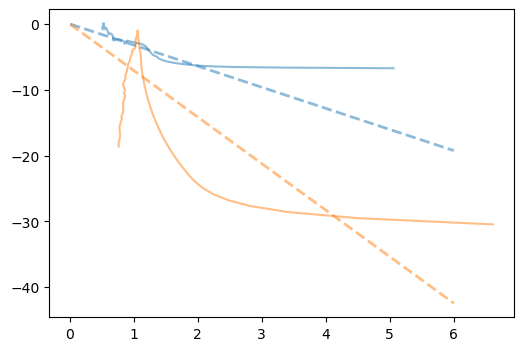

In [504]:
# #DONE: compute dRdt vs. 1/R for R as RMSRdf_msd_lr=pd.read_csv(msr_dir_lr)
# t_values=df_msd_lr['tdeath_avg'].values
# R_values=np.sqrt(df_msd_lr['MSR'].values)
# Delta_R_values=df_msd_lr['Delta_MSR'].values/(2*R_values)
fontsize=15
fig,ax=plt.subplots(figsize=(6,4))
### plot expected
fontsize=20

# #DONE: recall savgol filter to compute dRdt_values

# plt.plot(t_values,R_values)
# # plt.plot(t_values_,R_values_)
# navg_ma=10
# plt.plot(moving_average(1/R_values_FK,navg_ma),-moving_average(dRdt_values_FK,navg_ma)*1e3)
# plt.plot(moving_average(1/R_values_LR,navg_ma),-moving_average(dRdt_values_LR,navg_ma)*1e3)
ax.plot(1/R_values_FK,-dRdt_values_FK*1e3,c='C0',alpha=alpha,label='Fenton-Karma')
ax.plot(1/R_values_LR,-dRdt_values_LR*1e3,c='C1',alpha=alpha,label='Luo-Rudy')
# ax.plot(1/R_values_FK,-dRdt_values_FK*5e2)
# ax.plot(1/R_values_LR,-dRdt_values_LR*5e2)

#plot the expected values
xv=np.linspace(1e-2,6,100)
# plt.plot(xv,-1.604153*2*xv,'C0--',lw=2,alpha=0.5)
# ax.plot(xv,-1.8876*2*xv,'C0--',lw=2,alpha=0.5)
plt.plot(xv,-1.604153*2*xv,'C0--',lw=2,alpha=0.5)
# plt.plot(xv,-8.595018*2*xv,'C1--',lw=2,alpha=0.5)
# ax.plot(xv,-9.60637*2*xv,'C1--',lw=2,alpha=0.5)
ax.plot(xv,-3.535902*2*xv,'C1--',lw=2,alpha=0.5)


plt.show()

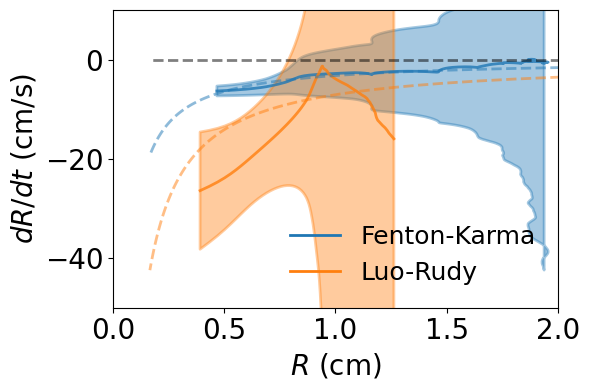

In [505]:
# #DONE: compute dRdt vs. 1/R for R as RMSRdf_msd_lr=pd.read_csv(msr_dir_lr)
# t_values=df_msd_lr['tdeath_avg'].values
# R_values=np.sqrt(df_msd_lr['MSR'].values)
# Delta_R_values=df_msd_lr['Delta_MSR'].values/(2*R_values)
fontsize=15
fig,ax=plt.subplots(figsize=(6,4))
### plot expected
fontsize=20
# ax.scatter(1/R_values_FK,-dRdt_values_FK*1e3,c='C0',s=40,alpha=alpha,label='Fenton-Karma')
# # ax.scatter(1/R_values_LR,-dRdt_values_LR*1e3,c='C1',s=40,alpha=alpha,label='Luo-Rudy')
# ax.scatter(R_values_FK,-dRdt_values_FK*1e3,c='C0',s=40,alpha=alpha,label='Fenton-Karma')
# ax.scatter(R_values_LR,-dRdt_values_LR*1e3,c='C1',s=40,alpha=alpha,label='Luo-Rudy')

#plot data
ax.plot(x_values_FK,y_values_FK,lw=2,alpha=0.8,c='C0',label='Fenton-Karma')
ax.fill_between(x_values_FK,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
ax.plot(x_values_LR,y_values_LR,lw=2,alpha=0.8,c='C1',label='Luo-Rudy')
ax.fill_between(x_values_LR,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')
#plot fits


#plot the expected values
xv=np.linspace(1e-2,6,100)
# plt.plot(xv,-1.604153*2*xv,'C0--',lw=2,alpha=0.5)
# ax.plot(xv,-1.8876*2*xv,'C0--',lw=2,alpha=0.5)
plt.plot(1/xv,-1.604153*2*xv,'C0--',lw=2,alpha=0.5)
# plt.plot(xv,-8.595018*2*xv,'C1--',lw=2,alpha=0.5)
# ax.plot(xv,-9.60637*2*xv,'C1--',lw=2,alpha=0.5)
ax.plot(1/xv,-3.535902*2*xv,'C1--',lw=2,alpha=0.5)

ax.plot(1/xv,0*xv,'k--',lw=2,alpha=0.5)



#format
x1lim=[0,2]
x2lim=[-50,10]
FormatAxes(
    ax,
    x1lim=x1lim,
    x2lim=x2lim,
    x1label=r'$R$ (cm)',  #q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
    x2label=r'$dR/dt$ (cm/s)',  #w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
    title=None,
    fontsize=fontsize,
    use_loglog=False)
ax.annotate(r"best fit ($a>0$)", xy=(0.3, 11), xytext=xytext,fontsize=fontsize)
leg=ax.legend(loc='lower right',fontsize=fontsize-2,frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

# ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=1)
#wrong bluf because aggregate
plt.tight_layout()
plt.show()

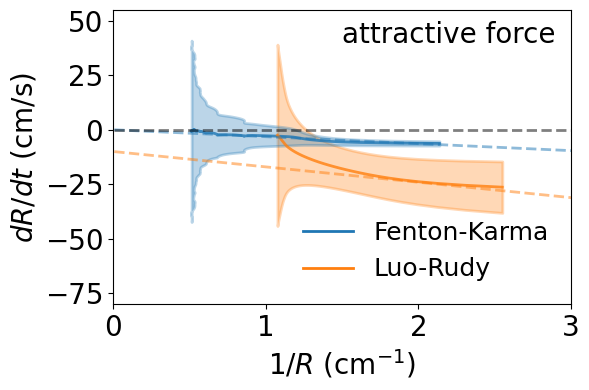

In [556]:
# #DONE: compute dRdt vs. 1/R for R as RMSRdf_msd_lr=pd.read_csv(msr_dir_lr)
# t_values=df_msd_lr['tdeath_avg'].values
# R_values=np.sqrt(df_msd_lr['MSR'].values)
# Delta_R_values=df_msd_lr['Delta_MSR'].values/(2*R_values)
fontsize=15
fig,ax=plt.subplots(figsize=(6,4))
### plot expected
fontsize=20
# ax.scatter(1/R_values_FK,-dRdt_values_FK*1e3,c='C0',s=40,alpha=alpha,label='Fenton-Karma')
# # ax.scatter(1/R_values_LR,-dRdt_values_LR*1e3,c='C1',s=40,alpha=alpha,label='Luo-Rudy')
# ax.scatter(R_values_FK,-dRdt_values_FK*1e3,c='C0',s=40,alpha=alpha,label='Fenton-Karma')
# ax.scatter(R_values_LR,-dRdt_values_LR*1e3,c='C1',s=40,alpha=alpha,label='Luo-Rudy')

#plot data
ax.plot(1/x_values_FK,y_values_FK,lw=2,alpha=0.8,c='C0',label='Fenton-Karma')
ax.fill_between(1/x_values_FK,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.3,color='C0')
# ax.plot(1/x_values_LR,y_values_LR,lw=2,alpha=0.8,c='C1',label='Luo-Rudy')
# ax.fill_between(1/x_values_LR,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.3,color='C1',zorder=0)
boo=1/x_values_LR>1/0.93
ax.plot(1/x_values_LR[boo],y_values_LR[boo],lw=2,alpha=0.8,c='C1',label='Luo-Rudy')
ax.fill_between(1/x_values_LR[boo],y_values_LR[boo]-yerr_values_LR[boo],y_values_LR[boo]+yerr_values_LR[boo],lw=2,alpha=0.3,color='C1',zorder=0)

#plot the expected values
xv=np.linspace(1e-2,6,100)
# plt.plot(xv,-1.604153*2*xv,'C0--',lw=2,alpha=0.5)
# ax.plot(xv,-1.8876*2*xv,'C0--',lw=2,alpha=0.5)
plt.plot(xv,-1.604153*2*xv,'C0--',lw=2,alpha=0.5)
# plt.plot(xv,-8.595018*2*xv,'C1--',lw=2,alpha=0.5)
# ax.plot(xv,-9.60637*2*xv,'C1--',lw=2,alpha=0.5)
ax.plot(xv,-3.535902*2*xv-10,'C1--',lw=2,alpha=0.5)

ax.plot(xv,0*xv,'k--',lw=2,alpha=0.5)



#format
x1lim=[0,3]
x2lim=[-80,55]
FormatAxes(
    ax,
    x1lim=x1lim,
    x2lim=x2lim,
    x1label=r'$1/R$ (cm$^{-1}$)',  #q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
    x2label=r'$dR/dt$ (cm/s)',  #w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
    title=None,
    fontsize=fontsize,
    use_loglog=False)
# xytext=(0.09, 10)
# ax.annotate(r"attractive force", xy=(0.3, 11), xytext=xytext,fontsize=fontsize)
xytext=(1.5, 40)
ax.annotate(r"attractive force", xy=(0.3, 11), xytext=xytext,fontsize=fontsize)
leg=ax.legend(loc='lower right',fontsize=fontsize-2,frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)

ax.set_yticks([-75,-50,-25,0,25,50])
    
# ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=1)
#wrong bluf because aggregate
plt.tight_layout()
plt.show()

(0.09, 10)

In [470]:
# fontsize=15
# fig,ax=plt.subplots(figsize=(6,4))
# ### plot expected
# fontsize=20

# xv=np.linspace(0,1e3,200)
# ax.plot(xv,4*a_hat_LR*1e-3*xv,'--',lw=2,alpha=0.8,c='C1')
# ax.plot(xv,4*a_hat_FK*1e-3*xv,'--',lw=2,alpha=0.8,c='C0')
# #plot data
# ax.plot(x_values_FK,y_values_FK,lw=2,alpha=0.8,c='C0')
# ax.fill_between(x_values_FK,y_values_FK-yerr_values_FK,y_values_FK+yerr_values_FK,lw=2,alpha=0.4,color='C0')
# ax.plot(x_values_LR,y_values_LR,lw=2,alpha=0.8,c='C1')
# ax.fill_between(x_values_LR,y_values_LR-yerr_values_LR,y_values_LR+yerr_values_LR,lw=2,alpha=0.4,color='C1')

# # MSR(t)=at + (2D/\omega) \sin(\omega t + \phi_f),
# # DONE: plot ^this model for MSR for fitty parameter settings (LR)
# # a=3.535902;D=a/2;phi_f=0.;period=0.1 #s
# a=3.535902;D=a/2;
# phi_f=0.;
# # phi_f=-np.pi/2;
# period=0.12 #s
# omega=2*np.pi/period
# constant=-8*D*np.sin(phi_f)/omega#0.15
# t_values=np.linspace(0,1,1000)
# MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
# ax.plot(t_values*1e3,MSR_values_oscillatory,c='C2',
#         label='$MSR_{Osc.} (a=a_{LR},\phi_f=0$)')
# #         label=r'Oscillatory Solution ($a=a_{LR}$, $\phi_f=0$)')

# #what param setting to use for the FK model?
# phi_f=-np.pi/2;
# a=1.604153;
# period=0.11 #s
# D=a/2;
# # constant=0.15
# omega=2*np.pi/period
# constant=-8*D*np.sin(phi_f)/omega#0.15
# t_values=np.linspace(0,1,1000)
# MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
# ax.plot(t_values*1e3,MSR_values_oscillatory,c='C3',
#                 label=r'$MSR_{Osc.} (a=a_{FK}, \phi_f=-\frac{\pi}{2})$')
# #         label='$MSR_{Osc.} (a=a_{FK}, \phi_f=-\frac{\pi}{2})$')
# #         label='Oscillatory Solution ($a=a_{FK}$, $\phi_f=-\pi/2$)')

# # #what param setting to use for the FK model?
# # phi_f=0#-np.pi/2;
# # # a=1.604153;
# # # period=0.11 #s
# # # D=a/2;
# # # constant=0.15
# # omega=2*np.pi/period
# # constant=-8*D*np.sin(phi_f)/omega#0.15
# # t_values=np.linspace(0,1,1000)
# # MSR_values_oscillatory=4*(a*t_values+(2*D/omega)*np.sin(omega*t_values+phi_f))+constant
# # plt.plot(t_values*1e3,MSR_values_oscillatory,c='gray',label='Oscillatory Solution ($a=a_{FK}$, $\phi_f=0$)')

# #format plot
# format_plot(ax=ax,xlabel=r'$t_f-t$ (ms)',ylabel=r'MSR (cm$^2$)',fontsize=fontsize)
# plt.xlim([0,1000])
# plt.ylim([0,5.1])
# plt.legend(loc='lower right',fontsize=fontsize-5,frameon=False)
# plt.show()
# # print(f"tavg2={tavg2} ms, num_samples={max_num_groups}")

## (old version) dRdt vs. 1/R for annihilation events

In [40]:
# search_for_file(os.path.dirname(input_fn))

input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/annihilations_mindur_50_maxdur_150_minrange_0.5_rangethresh_0.1_mean_radial_velocities_bins_30_minRthresh_0.2_maxspeedthresh_0.5.csv'

In [76]:
#LR results for DT = 0.5 ms
# modelname='luo-rudy'
#annihilations aggregated
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/annihilations_minr_1.0_mindur_20.0.csv"
# df_lr=pd.read_csv(input_fn)

# #LR results for DT = 0.025 ms
#annihilations aggregated
# input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.025/annihilations_minr_1.0_mindur_20.0.csv'
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/annihilations_minr_1.0_mindur_20.0.csv"
# # #creations aggregated
# input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.025/creations_minr_1.0_mindur_20.0.csv'

df_lr=pd.read_csv(input_fn)
# #FK results for DT = 0.4 ms
# #annihilations aggregated
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/annihilations_minr_1.0_mindur_20.0.csv"
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/annihilations_minr_1.0_mindur_20.0.csv"



# input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/annihilations_mindur_50_maxdur_150_minrange_0.5_rangethresh_0.1_mean_radial_velocities_bins_30_minRthresh_0.2_maxspeedthresh_0.5.csv'
# input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/annihilations_mindur_50_maxdur_150_minrange_0.5_rangethresh_0.1_mean_radial_velocities_bins_30.csv'

# #creations aggregated
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/creations_minr_1.0_mindur_20.0.csv"
df_fk=pd.read_csv(input_fn)

In [77]:
# #LR results for DT = 0.5 ms
# # modelname='luo-rudy'
# #annihilations aggregated
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/annihilations_minr_1.0_mindur_20.0.csv"


# # #LR results for DT = 0.025 ms
# #annihilations aggregated
# # input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.025/annihilations_minr_1.0_mindur_20.0.csv'
# # # #creations aggregated
# # input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.025/creations_minr_1.0_mindur_20.0.csv'
# df_lr=pd.read_csv(input_fn)

# # #FK results for
# # #annihilations aggregated
# #DT = 0.4 ms
# # input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/annihilations_minr_1.0_mindur_20.0.csv"
# #DT=0.025 ms
# input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_30_diffCoef_0.001_dt_0.025/annihilations_minr_1.0_mindur_20.0.csv'
# df_fk=pd.read_csv(input_fn)

# # input_fn=search_for_file()
# #TODO: make outputs simultaneously visible for LR and FK results (dt=0.5,0.4, respectively)

In [96]:
df_fk['tdeath']
df_fk.head()

,pid,pid_deathmate,tdeath,phi1,phi2,phi_sum,phi_diff,r,theta
2022508,323,319,0.4,0.290670,0.265307,0.025363,0.555978,0.210981,0.309262
506595,65,60,0.4,0.547026,0.484770,0.062256,1.031796,0.181260,0.545626
2016360,234,230,0.4,0.250357,0.230122,0.020235,0.480479,0.164212,0.305135
853772,29,19,0.4,0.468442,0.422671,0.045771,0.891114,0.144394,0.536775
1833408,176,172,0.4,0.173274,0.151883,0.021391,0.325158,0.033116,0.170509


In [79]:
df_fk.sort_values('tdeath',ascending=True,inplace=True)
df_lr.sort_values('tdeath',ascending=True,inplace=True)

In [80]:
# print(f"number of trials is {len(sorted(set(df_lr.pid.values)))} (LR) and {len(sorted(set(df_fk.pid.values)))} (FK).")

#compute xy values
x_label='time (ms)'#'t'
# x_label='time after annihilation (ms)'#'t'
y_label='inward/outward\nangle (radians)'#'$\vartheta$'
# 'r (cm)'
# 'dr/dt (cm/ms)'

df_phases=df_lr.copy()
t_values=sorted(set(df_phases.tdeath.values))
DT=sorted(set(df_phases.tdeath.values))[0]
#compute/plot average over particles
N=len(list(set(df_phases.pid.values)))
# dfm=df_phases.groupby('tbirth').mean()
# dfs=df_phases.groupby('tbirth').std()
dfm=df_phases.groupby('tdeath').mean()
dfs=df_phases.groupby('tdeath').std()
x_values_lr=dfm.index.values
y_values_lr=dfm.theta.values
yerr_values_lr=dfs.theta.values

df_phases=df_fk.copy()
t_values=sorted(set(df_phases.tdeath.values))
DT=sorted(set(df_phases.tdeath.values))[0]
#compute/plot average over particles
N=len(list(set(df_phases.pid.values)))
# dfm=df_phases.groupby('tbirth').mean()
# dfs=df_phases.groupby('tbirth').std()
dfm=df_phases.groupby('tdeath').mean()
dfs=df_phases.groupby('tdeath').std()
x_values_fk=dfm.index.values
y_values_fk=dfm.theta.values
yerr_values_fk=dfs.theta.values

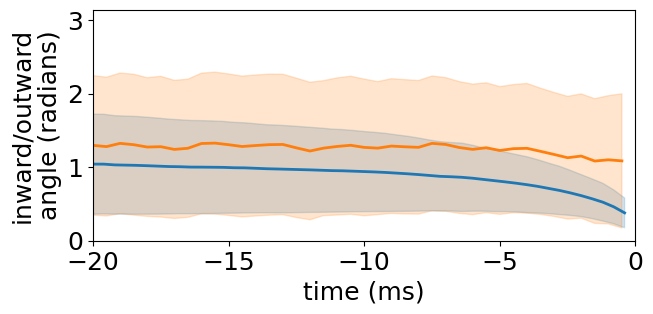

In [81]:
fontsize=18
fig,ax=plt.subplots(ncols=1,figsize=(7,3))#(5,4))
# axes=[1e-1,2,1e-3,0.2]
alpha=0.2
# FK
ax.fill_between(-x_values_fk, y_values_fk-yerr_values_fk, y_values_fk+yerr_values_fk,color='C0',alpha=alpha)
ax.plot(-x_values_fk,y_values_fk,'C0',lw=2)
#LR
ax.fill_between(-x_values_lr, y_values_lr-yerr_values_lr, y_values_lr+yerr_values_lr,color='C1',alpha=alpha)
ax.plot(-x_values_lr,y_values_lr,'C1',lw=2)

#TODO: add cuts for times



ax.set_xlim([-20,0])#-DT])
# ax.set_xlim([-50,-DT])
ax.set_ylim([0,np.pi])
ax.set_xlabel(x_label,fontsize=fontsize)
ax.set_ylabel(y_label,fontsize=fontsize)
# ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=1)

#wrong bluf because aggregate
# print(f"number of trials is {len(sorted(set(df_lr.pid.values)))} (LR) and {len(sorted(set(df_fk.pid.values)))} (FK).")
plt.show()

In [117]:
#plot the mean drdt versus r
#compute xy values
x_label='R (cm)'
y_label='dR/dt (cm/ms)'

df_fk.sort_values('tdeath',ascending=True,inplace=True)
df_lr.sort_values('tdeath',ascending=True,inplace=True)

df_phases=df_lr.copy()
t_values=sorted(set(df_phases.tdeath.values))
DT=sorted(set(df_phases.tdeath.values))[0]
#compute/plot average over particles
N=len(list(set(df_phases.pid.values)))
# dfm=df_phases.groupby('tbirth').mean()
# dfs=df_phases.groupby('tbirth').std()
dfm=df_phases.groupby('tdeath').mean()
dfs=df_phases.groupby('tdeath').std()
t_values=dfm.index.values
range_values=dfm.r.values
drdt_values=np.diff(range_values)/DT
r_values=range_values[1:]/2+range_values[:-1]/2
x_values_lr=r_values.copy()
y_values_lr=drdt_values.copy()
# yerr_values_lr=dfs.theta.values

#fit drdt_values to F0+F1/r with OLS fit for LR model where 1/r is greater than some 1/cm
rmax=1.2 #cm
boo=r_values<rmax
x=1/r_values[boo]
y=drdt_values[boo]
dict_force_fit=compute_95CI_ols(x,y)
y_hat_values=dict_force_fit['b']+dict_force_fit['m']/r_values

dict_force_fit_lr=dict_force_fit
y_hat_values_lr=y_hat_values.copy()

df_phases=df_fk.copy()
t_values=sorted(set(df_phases.tdeath.values))
DT=sorted(set(df_phases.tdeath.values))[0]
#compute/plot average over particles
N=len(list(set(df_phases.pid.values)))
# dfm=df_phases.groupby('tbirth').mean()
# dfs=df_phases.groupby('tbirth').std()
dfm=df_phases.groupby('tdeath').mean()
dfs=df_phases.groupby('tdeath').std()
t_values=dfm.index.values
range_values=dfm.r.values
drdt_values=np.diff(range_values)/DT
r_values=range_values[1:]/2+range_values[:-1]/2
x_values_fk=r_values.copy()
y_values_fk=drdt_values.copy()
# yerr_values_fk=dfs.theta.values

#fit drdt_values to F0+F1/r with OLS fit for FK model where 1/r is greater than 2 1/cm
rmax=0.5 #cm
boo=r_values<rmax
x=1/r_values[boo]
y=drdt_values[boo]
dict_force_fit=compute_95CI_ols(x,y)
y_hat_values=dict_force_fit['b']+dict_force_fit['m']/r_values
dict_force_fit_fk=dict_force_fit
y_hat_values_fk=y_hat_values.copy()
DT

0.4

In [118]:
print(f"the best fits are\n {dict_force_fit_lr} (LR) and \n{dict_force_fit_fk} (FK).")

the best fits are
 {'m': -0.04422231513736983, 'Delta_m': 0.05564659598723808, 'b': 0.038442644486729995, 'Delta_b': 0.05347057224331184, 'Rsquared': 0.012351468067116794} (LR) and 
{'m': 0.03728256788539019, 'Delta_m': 0.0006336154335623624, 'b': -0.048669499427550326, 'Delta_b': 0.001794174887640679, 'Rsquared': 0.9990235572199276} (FK).


In [84]:
# def print_dict(input_dict):
#     for key in input_dict.keys():
#         print(f"{key}={input_dict[key]}")
r_values

array([0.21120453, 0.25593874, 0.29152921, ..., 1.83470333, 1.83077765,
       1.82552717])

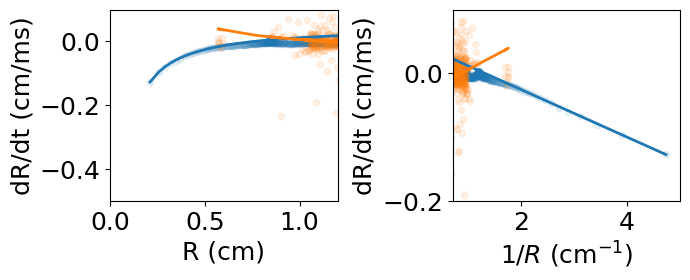

In [86]:
fontsize=18
alpha=0.1

fig,axs=plt.subplots(ncols=2,figsize=(7,3))#(5,4))
ax=axs[0]
ax.scatter(x_values_fk,-y_values_fk,c='C0',s=20,alpha=alpha)
ax.scatter(x_values_lr,-y_values_lr,c='C1',s=20,alpha=alpha)

#plot fits
ax.plot(x_values_fk,-y_hat_values_fk,c='C0',lw=2,alpha=1)
ax.plot(x_values_lr,-y_hat_values_lr,c='C1',lw=2,alpha=1)

ax.set_xlim([0,1.2])
ax.set_ylim([-0.5,.1])
ax.set_xlabel(x_label,fontsize=fontsize)
ax.set_ylabel(y_label,fontsize=fontsize)
# ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=1)

ax=axs[1]
ax.scatter(1/x_values_fk,-y_values_fk,c='C0',s=20,alpha=alpha)
ax.scatter(1/x_values_lr,-y_values_lr,c='C1',s=20,alpha=alpha)

#plot fits
ax.plot(1/x_values_fk,-y_hat_values_fk,c='C0',lw=2,alpha=1)
ax.plot(1/x_values_lr,-y_hat_values_lr,c='C1',lw=2,alpha=1)

# y_hat_values_fk
# y_hat_values_fk

ax.set_xlim([.7,5])
ax.set_ylim([-0.2,.1])
ax.set_xlabel(r'$1/R$ (cm$^{-1}$)',fontsize=fontsize)
ax.set_ylabel(y_label,fontsize=fontsize)

# ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=1)
#wrong bluf because aggregate
plt.tight_layout()
plt.show()

$$
F(R)\propto\frac{dR}{dt} = b + \frac{m}{R}
$$

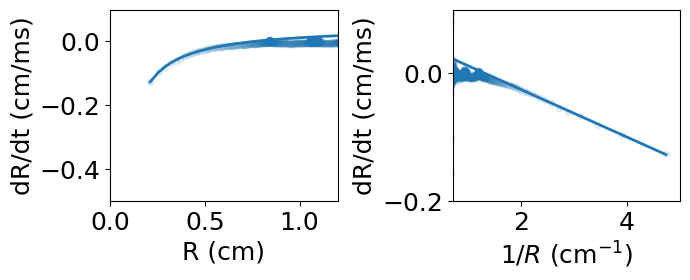

In [97]:
fontsize=18
alpha=0.1

fig,axs=plt.subplots(ncols=2,figsize=(7,3))#(5,4))
ax=axs[0]
ax.scatter(x_values_fk,-y_values_fk,c='C0',s=20,alpha=alpha)
# ax.scatter(x_values_lr,-y_values_lr,c='C1',s=20,alpha=alpha)

#plot fits
ax.plot(x_values_fk,-y_hat_values_fk,c='C0',lw=2,alpha=1)
# ax.plot(x_values_lr,-y_hat_values_lr,c='C1',lw=2,alpha=1)

ax.set_xlim([0,1.2])
ax.set_ylim([-0.5,.1])
ax.set_xlabel(x_label,fontsize=fontsize)
ax.set_ylabel(y_label,fontsize=fontsize)
# ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=1)

ax=axs[1]
ax.scatter(1/x_values_fk,-y_values_fk,c='C0',s=20,alpha=alpha)
# ax.scatter(1/x_values_lr,-y_values_lr,c='C1',s=20,alpha=alpha)

#plot fits
ax.plot(1/x_values_fk,-y_hat_values_fk,c='C0',lw=2,alpha=1)
# ax.plot(1/x_values_lr,-y_hat_values_lr,c='C1',lw=2,alpha=1)

# y_hat_values_fk
# y_hat_values_fk

ax.set_xlim([.7,5])
ax.set_ylim([-0.2,.1])
ax.set_xlabel(r'$1/R$ (cm$^{-1}$)',fontsize=fontsize)
ax.set_ylabel(y_label,fontsize=fontsize)

# ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=1)
#wrong bluf because aggregate
plt.tight_layout()
plt.show()

In [124]:
a_fk=dict_force_fit_fk['m']/2*1000
a_fk=dict_force_fit_fk['m']/2*100
Delta_a_fk=dict_force_fit_fk['Delta_m']/2*100
print(f'the apparent attraction coefficient for the fenton-karma model is a={a_fk:.4f} +/- {Delta_a_fk:.4f} cm^2/s.')

the apparent attraction coefficient for the fenton-karma model is a=1.8641 +/- 0.0317 cm^2/s.


In [122]:
nobs=df_fk.groupby('tdeath').r.count().iloc[0]
print(f"nobs={nobs} (FK)")
nobs=df_lr.groupby('tdeath').r.count().iloc[0]
print(f"nobs={nobs} (LR)")

nobs=3010 (FK)
nobs=744 (LR)


In [85]:
#TODO: try any more annihilation plots... 
# HINT: any from the following 3 panel
# HINT: are phi values present/convenient? Yes.
#TODO: condense the figures we like into functions. test on FK model
#TODO: make comparable functions for LR model. 

In [52]:
print(f"the ols fit for FK:")
print_dict(dict_force_fit_fk)
print(f"\nthe ols fit for LR:")
print_dict(dict_force_fit_lr)

the ols fit for FK:
m=0.03728256788539025
Delta_m=0.0006336154335623547
b=-0.04866949942755054
Delta_b=0.0017941748876406575
Rsquared=0.9990235572199276

the ols fit for LR:
m=-0.04422231513736985
Delta_m=0.05564659598723807
b=0.03844264448673002
Delta_b=0.05347057224331182
Rsquared=0.012351468067116686


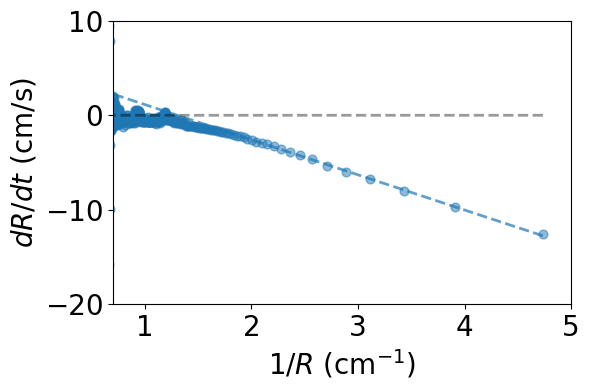

In [132]:
#plot the best fits when a>0
fontsize = 20
figsize = (6, 4)  #(5,4)
alpha=0.5
fig, ax = plt.subplots(figsize=figsize)

# #plot the full models
# ax.scatter(fk['q'].values,fk['w'].values,c='C0',alpha=0.2,s=40,label='Fenton-Karma',zorder=0)
# ax.scatter(lr['q'].values,lr['w'].values,c='C1',alpha=0.2,s=40,label='Luo-Rudy',zorder=0)

# #plot the result over the original annihilation rates
# plt.plot(q_values_fk,what_values_fk,'--',c='C0',label=f'_Fit to FK',alpha=1,lw=2)
# plt.plot(q_values_lr,what_values_lr,'--',c='C1',label=f'_Fit to LR',alpha=1,lw=2)

ax.scatter(1/x_values_fk,-y_values_fk*100,c='C0',s=40,alpha=alpha,label='Fenton-Karma')
# ax.scatter(1/x_values_lr,-y_values_lr*100,c='C1',s=40,alpha=alpha,label='Luo-Rudy',zorder=0)

#plot fits
y_hat_values=dict_force_fit_fk['b']*100+dict_force_fit_fk['m']*100/x_values_fk
ax.plot(1/x_values_fk,-y_hat_values,'--',c='C0',lw=2,alpha=0.7)
# ax.plot(1/x_values_fk,-y_hat_values_fk*100,'--',c='C0',lw=2,alpha=1)
# ax.plot(1/x_values_lr,-y_hat_values_lr*100,'--',c='C1',lw=2,alpha=1)
ax.plot(1/x_values_fk,0.*y_hat_values,'k--',lw=2,alpha=0.4)



#format
x1lim=[.7,5]
x2lim=[-0.2e2,.1e2]
FormatAxes(
    ax,
    x1lim=x1lim,
    x2lim=x2lim,
    x1label=r'$1/R$ (cm$^{-1}$)',  #q$ (1/cm$^{2}$)',#r'$q=N/A$ (1/cm$^{2}$)',
    x2label=
    r'$dR/dt$ (cm/s)',  #w$ (Hz/cm$^{2}$)',#r'$w=W_{-2}/A$ (Hz/cm$^{2}$)',
    title=None,
    fontsize=fontsize,
    use_loglog=False)
ax.annotate(r"best fit ($a>0$)", xy=(0.3, 11), xytext=xytext,fontsize=fontsize)
# leg=ax.legend(loc='upper right',fontsize=fontsize-2,frameon=False)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
# #mark the slope of ^that line with ~2
# x1 = 1
# y1 = 0.1
# annotation.slope_marker(origin=(x1, y1),
#                         slope=2,
#                         text_kwargs={'color': 'black','fontsize':16, 'alpha':0.7},
#                         poly_kwargs={'facecolor': (0.5, 0.5, 0.5), 'alpha':0.5},#TODO: replace with purple
#                         ax=ax)

# ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=1)
#wrong bluf because aggregate
plt.tight_layout()
plt.show()

## (old version, supplementary) dRdt vs 1/R for creation events

In [63]:
# LR results for DT = 0.5 ms
modelname='luo-rudy'
# annihilations aggregated
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/annihilations_minr_1.0_mindur_20.0.csv"
# # # #creations aggregated
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.5/creations_minr_1.0_mindur_20.0.csv"
df_lr=pd.read_csv(input_fn)

# #LR results for DT = 0.025 ms
# #annihilations aggregated
# # input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.025/annihilations_minr_1.0_mindur_20.0.csv'
# # # #creations aggregated
# input_fn='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-3-LR/param_qu_tmax_30_Ko_5.4_diffCoef_0.0005_dt_0.025/creations_minr_1.0_mindur_20.0.csv'

# df_lr=pd.read_csv(input_fn)
# #FK results for DT = 0.4 ms
# #annihilations aggregated
# input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/annihilations_minr_1.0_mindur_20.0.csv"
# #creations aggregated
input_fn="/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-fk-200x200/param_set_8_ds_5.0_tmax_10_diffCoef_0.0005/creations_minr_1.0_mindur_20.0.csv"
df_fk=pd.read_csv(input_fn)

In [65]:
df_fk.sort_values('tbirth',ascending=True,inplace=True)
df_lr.sort_values('tbirth',ascending=True,inplace=True)

In [66]:
# print(f"number of trials is {len(sorted(set(df_lr.pid.values)))} (LR) and {len(sorted(set(df_fk.pid.values)))} (FK).")

#compute xy values
x_label='time (ms)'#'t'
# x_label='time after annihilation (ms)'#'t'
y_label='inward/outward\nangle (radians)'#'$\vartheta$'
# 'r (cm)'
# 'dr/dt (cm/ms)'

df_phases=df_lr.copy()
t_values=sorted(set(df_phases.tbirth.values))
DT=sorted(set(df_phases.tbirth.values))[0]
#compute/plot average over particles
N=len(list(set(df_phases.pid.values)))
dfm=df_phases.groupby('tbirth').mean()
dfs=df_phases.groupby('tbirth').std()
# dfm=df_phases.groupby('tdeath').mean()
# dfs=df_phases.groupby('tdeath').std()
x_values_lr=dfm.index.values
y_values_lr=dfm.theta.values
yerr_values_lr=dfs.theta.values

df_phases=df_fk.copy()
t_values=sorted(set(df_phases.tbirth.values))
DT=sorted(set(df_phases.tbirth.values))[0]
#compute/plot average over particles
N=len(list(set(df_phases.pid.values)))
dfm=df_phases.groupby('tbirth').mean()
dfs=df_phases.groupby('tbirth').std()
# dfm=df_phases.groupby('tdeath').mean()
# dfs=df_phases.groupby('tdeath').std()
x_values_fk=dfm.index.values
y_values_fk=dfm.theta.values
yerr_values_fk=dfs.theta.values

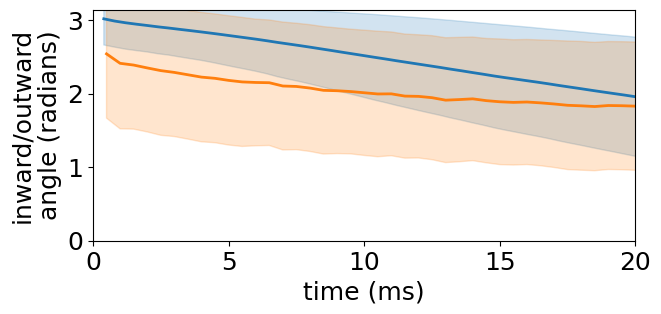

In [67]:
fontsize=18
fig,ax=plt.subplots(ncols=1,figsize=(7,3))#(5,4))
# axes=[1e-1,2,1e-3,0.2]
alpha=0.2
# FK
ax.fill_between(x_values_fk, y_values_fk-yerr_values_fk, y_values_fk+yerr_values_fk,color='C0',alpha=alpha)
ax.plot(x_values_fk,y_values_fk,'C0',lw=2)
#LR
ax.fill_between(x_values_lr, y_values_lr-yerr_values_lr, y_values_lr+yerr_values_lr,color='C1',alpha=alpha)
ax.plot(x_values_lr,y_values_lr,'C1',lw=2)

#TODO: add cuts for times



ax.set_xlim([0,20])#-DT])
# ax.set_xlim([-50,-DT])
ax.set_ylim([0,np.pi])
ax.set_xlabel(x_label,fontsize=fontsize)
ax.set_ylabel(y_label,fontsize=fontsize)
# ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=1)

#wrong bluf because aggregate
# print(f"number of trials is {len(sorted(set(df_lr.pid.values)))} (LR) and {len(sorted(set(df_fk.pid.values)))} (FK).")
plt.show()

In [70]:
#plot the mean drdt versus r
#compute xy values
x_label='R (cm)'
y_label='dR/dt (cm/ms)'

df_fk.sort_values('tbirth',ascending=True,inplace=True)
df_lr.sort_values('tbirth',ascending=True,inplace=True)

df_phases=df_lr.copy()
t_values=sorted(set(df_phases.tbirth.values))
DT=sorted(set(df_phases.tbirth.values))[0]
#compute/plot average over particles
N=len(list(set(df_phases.pid.values)))
dfm=df_phases.groupby('tbirth').mean()
dfs=df_phases.groupby('tbirth').std()
# dfm=df_phases.groupby('tdeath').mean()
# dfs=df_phases.groupby('tdeath').std()
t_values=dfm.index.values
range_values=dfm.r.values
drdt_values=np.diff(range_values)/DT
r_values=range_values[1:]/2+range_values[:-1]/2
x_values_lr=r_values
y_values_lr=drdt_values
# yerr_values_lr=dfs.theta.values

#fit drdt_values to F0+F1/r with OLS fit for LR model where 1/r is greater than some 1/cm
rmax=1.8 #cm
boo=r_values<rmax
x=1/r_values[boo]**2
y=drdt_values[boo]

# boo=y<0.4
boo=y<0.4
x_lr=x[boo]
y_lr=y[boo]

dict_force_fit=compute_95CI_ols(x_lr,y_lr)
y_hat_values=dict_force_fit['b']+dict_force_fit['m']/r_values**2

x_lr=x.copy()
y_lr=y.copy()

dict_force_fit_lr=dict_force_fit
y_hat_values_lr=y_hat_values

df_phases=df_fk.copy()
t_values=sorted(set(df_phases.tbirth.values))
DT=sorted(set(df_phases.tbirth.values))[0]
#compute/plot average over particles
N=len(list(set(df_phases.pid.values)))
dfm=df_phases.groupby('tbirth').mean()
dfs=df_phases.groupby('tbirth').std()
# dfm=df_phases.groupby('tdeath').mean()
# dfs=df_phases.groupby('tdeath').std()
t_values=dfm.index.values
range_values=dfm.r.values
drdt_values=np.diff(range_values)/DT
r_values=range_values[1:]/2+range_values[:-1]/2
x_values_fk=r_values
y_values_fk=drdt_values
# yerr_values_fk=dfs.theta.values

#fit drdt_values to F0+F1/r with OLS fit for FK model where 1/r is greater than 2 1/cm
rmax=.8#0.5 #cm
boo=r_values<rmax
x=1/r_values[boo]
y=drdt_values[boo]
dict_force_fit=compute_95CI_ols(x,y)
y_hat_values=dict_force_fit['b']+dict_force_fit['m']/r_values
dict_force_fit_fk=dict_force_fit
y_hat_values_fk=y_hat_values

print(f"the best fits are\n {dict_force_fit_lr} (LR) and \n{dict_force_fit_fk} (FK).")

the best fits are
 {'m': 0.007649030453349954, 'Delta_m': 0.013928840348237402, 'b': -0.0030468118356572825, 'Delta_b': 0.010217246058971131, 'Rsquared': 0.0018801935544889902} (LR) and 
{'m': 0.04284740300370185, 'Delta_m': 0.00040537812866687996, 'b': -0.02691653702650268, 'Delta_b': 0.0007756105478584457, 'Rsquared': 0.9994178343464858} (FK).


In [71]:
def print_dict(input_dict):
    for key in input_dict.keys():
        print(f"{key}={input_dict[key]}")

In [72]:
# #TODO: use better binning/averaging?  There are weird values popping up on the y axis...
# boo=y_lr<0.4
# plt.plot(x_lr[boo],y_lr[boo])
# plt.xscale('log')
# plt.yscale('log')
# print(compute_95CI_ols(np.log(x_lr[boo]),np.log(y_lr[boo])))
# plt.show()
# {'m': 1.1150177782249635, 'Delta_m': 0.0352362804512445, 'b': -3.5472307622899737, 'Delta_b': 0.03130914035225103, 'Rsquared': 0.9632068040661317}

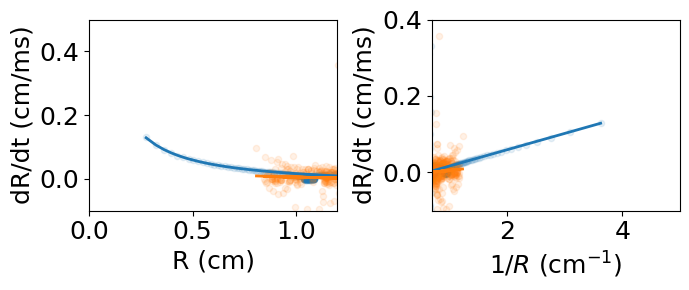

In [73]:
fontsize=18
alpha=0.1

fig,axs=plt.subplots(ncols=2,figsize=(7,3))#(5,4))
ax=axs[0]
ax.scatter(x_values_fk,y_values_fk,c='C0',s=20,alpha=alpha)
ax.scatter(x_values_lr,y_values_lr,c='C1',s=20,alpha=alpha)

#plot fits
ax.plot(x_values_fk,y_hat_values_fk,c='C0',lw=2,alpha=1)
ax.plot(x_values_lr,y_hat_values_lr,c='C1',lw=2,alpha=1)

ax.set_xlim([0,1.2])
ax.set_ylim([-0.1,.5])
ax.set_xlabel(x_label,fontsize=fontsize)
ax.set_ylabel(y_label,fontsize=fontsize)
# ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=1)

ax=axs[1]
ax.scatter(1/x_values_fk,y_values_fk,c='C0',s=20,alpha=alpha)
ax.scatter(1/x_values_lr,y_values_lr,c='C1',s=20,alpha=alpha)

#plot fits
ax.plot(1/x_values_fk,y_hat_values_fk,c='C0',lw=2,alpha=1)
ax.plot(1/x_values_lr,y_hat_values_lr,c='C1',lw=2,alpha=1)

# y_hat_values_fk
# y_hat_values_fk

ax.set_xlim([.7,5])
ax.set_ylim([-0.1,.4])
ax.set_xlabel(r'$1/R$ (cm$^{-1}$)',fontsize=fontsize)
ax.set_ylabel(y_label,fontsize=fontsize)

# ax.set_xscale('log')
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=1)
#wrong bluf because aggregate
plt.tight_layout()
plt.show()

For creation events from the LR model,
$$
F(R
)\propto\frac{dR}{dt} = b + \frac{m}{R}
$$


In [74]:
#TODO: try any more annihilation plots... 
# HINT: any from the following 3 panel
# HINT: are phi values present/convenient? Yes.
#TODO: condense the figures we like into functions. test on FK model
#TODO: make comparable functions for LR model. 
print(f"the ols fit for FK:")
print_dict(dict_force_fit_fk)
print(f"\nthe ols fit for LR:")
print_dict(dict_force_fit_lr)

the ols fit for FK:
m=0.04284740300370185
Delta_m=0.00040537812866687996
b=-0.02691653702650268
Delta_b=0.0007756105478584457
Rsquared=0.9994178343464858

the ols fit for LR:
m=0.007649030453349954
Delta_m=0.013928840348237402
b=-0.0030468118356572825
Delta_b=0.010217246058971131
Rsquared=0.0018801935544889902


In [75]:
nobs=df_fk.groupby('tbirth').r.count().iloc[0]
print(f"nobs={nobs} (FK)")
nobs=df_lr.groupby('tbirth').r.count().iloc[0]
print(f"nobs={nobs} (LR)")

nobs=7866 (FK)
nobs=3853 (LR)


## scratchwerk

In [35]:
print("(FK):")
a=a_hat_FK_vlong
D=D_hat_FK#,wjr=wjr,interp=interp,ax=ax,
model_name='fk_pbc'#;c='C0'
# a=a_hat_LR;D=D_hat_LR#,wjr=wjr,interp=interp,ax=ax,
# model_name='lr_pbc'#;c='C1'
#compute annihilation rates fit to the LR model
nu_full=wjr[model_name]['m']
M_full=wjr[model_name]['M']
q_values=np.linspace(0,20)
w_values=M_full*q_values**nu_full

if model_name=='lr_pbc':
    model_name_string='Luo-Rudy'
elif model_name=='fk_pbc':
    model_name_string='Fenton-Karma'
else:
    model_name_string='??'


#set attraction coefficient to zero
a=0
    
#find a best r,kappa pair for a given a,D pair for a given full model
args=a,D,q_values,w_values,interp
bnds = ((1e-3, 2), (1e2, 1e4))
x0 = (0.1, 500)
# res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
mse=comp_mse_via_interp(res.x, *args)
rmse=np.sqrt(mse)


#compute the resulting annihilation rates
r=res.x[0]
kappa=res.x[1]
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
what_values=M*q_values**nu

q_values_fk=q_values.copy()
what_values_fk=what_values.copy()

#TODO: initialize changing parameters
print(f"initializing parameters to:")
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")
a0=float(a); D0=float(D); r0=float(r); kappa0=float(kappa);rmse0=float(rmse)
# dict_fk=dict(r=r,kappa=kappa,nu=nu,M=M,rmse=rmse,res=res)

(FK):
initializing parameters to:
a=0, D=0.365238, r=0.1, kappa=500.0, rmse=nan


In [36]:
#CONFIRMED: setting a=0 causes interp to become nan
#NOTE: ^this is consistent with my prior observation of a weird jump at a=0
#TODO: dev function that returns interp (r,kappa,D) conditioned on a=0

In [37]:
# interp=

In [38]:
#TODO: get interp working using an earlier example with the perturbation
X=np.array([[r0,kappa0,a0,D0]])
yhat = interp(X)
print(yhat)
nu=yhat[0,0]
M=yhat[0,1]
what_values=M*q_values**nu
#TODO: get interp working using an earlier example
# comp_rmse_via_interp
#TODO: show interp works for a perturbation
#TODO: make an array of guesses for interp
#TODO: compute the rmse for each
#TODO: return the smallest such parameter setting

[[nan nan]]


In [39]:
interp(np.array([[r,kappa,a,D],[r,kappa,a,D]]).T)

ValueError: number of dimensions in xi does not match x

In [ ]:
#initialize repeatably
a=float(a0); D=float(D0); r=float(r0); kappa=float(kappa0); rmse0=float(rmse)

In [ ]:
def perform_perturbation_D(a,D,r,kappa,dx):
    D*=(1+dx)
    return a,D,r,kappa
def perform_perturbation_r(a,D,r,kappa,dx):
    r*=(1+dx)
    return a,D,r,kappa
def perform_perturbation_kappa(a,D,r,kappa,dx):
    kappa*=(1+dx)
    return a,D,r,kappa

In [ ]:
q_values.shape,w_values.shape

In [ ]:
#option A: the high level approach
#DONE: make map from scalar r perturbation to mse
def fun_r(dx,a,D,r,kappa,q_values,w_values,interp):
    #perturb one parameter by a factor of 1+dx 
    a,D,r,kappa=perform_perturbation_r(a,D,r,kappa,dx)
    args=a,D,q_values,w_values,interp
    #compute loss function
    x=r,kappa
    argsp=a,D,q_values,w_values,interp
    mse=comp_mse_via_interp(x, *argsp)
    return mse

In [ ]:
perform_perturbation_r(a,D,r,kappa,dx),perform_perturbation_r(a,D,r,kappa,dx+1)

In [ ]:
def comp_mse_via_interp_simple(r,kappa,a,D,q_values,w_values,interp):
    '''compute the mean squared error from the xy values, q_values,w_values.
    the model uses the powerlaw fit returned by yhat = interp(np.array([[r,kappa,a,D]]))
    '''
    #interpolate nu and M using interp
    X=np.array([[r,kappa,a,D]])
    yhat = interp(X)
    nu=yhat[0,0]
    M=yhat[0,1]
    what_values=M*q_values**nu
    mse=np.mean((what_values-w_values)**2)
    return mse


In [ ]:
r,kappa,a,D,q_values,w_values,interp

In [ ]:
X=np.array([[r,kappa,a,D]])
yhat = interp(X)
nu=yhat[0,0]
M=yhat[0,1]
what_values=M*q_values**nu
mse=np.mean((what_values-w_values)**2)

In [ ]:
comp_mse_via_interp_simple(r,kappa,a,D,q_values,w_values,interp)

In [ ]:
#     a,D,r,kappa=perform_perturbation_r(a,D,r,kappa,dx)
#     args=a,D,q_values,w_values,interp
#compute loss function
x=r,kappa
argsp=a,D,q_values,w_values,interp
mse=comp_mse_via_interp(x, *argsp)
mse

In [ ]:
dx=1
fun_r(dx,a,D,r,kappa,q_values,w_values,interp)

In [ ]:
# can i iterate on an object of class returned by minimize?
# minimize?
trgt_parameter='r'
args=a,D,q_values,w_values,interp
fun=comp_fun_1D(res,args,trgt_parameter)
res_next=minimize_scalar(
    fun,
    bracket=None,
    bounds=None,
    args=args,
    method='brent',
    tol=None,
    options=None,
)

In [ ]:
#TODO: optimize r wrt mse

In [ ]:

#TODO: repeat ^that for any other desired parameters
#TODO: wrap ^that into a function
#TODO: iterate over ^that function 100 times
#TODO: plot the result
#TODO: increase the number of samples
#TODO: plot the result
#TODO: if the result didn't change, document, share, and go to bed.

In [ ]:
#option B: the low level approach
#TODO: perturb r
#TODO: measure change
#TODO: accept or deny

In [ ]:
#TODO: dev map from dict_res to dict_res
#map dict_res to args and the first parameter to be varied, r
#map dict_res to args and the next parameter to be varied, kappa
#map dict_res to args and the next parameter to be varied, D
#TODO: test ^that
#TODO: simply try simple 1D optimization (bounded tho)
#TODO(|failing ^that): try each available method for 1D optimization

In [ ]:
# fun=comp_fun_1D(res,args,trgt_parameter)
res_next=minimize_scalar(
    fun,
    bracket=None,
    bounds=None,
    args=(),
    method='brent',
    tol=None,
    options=None,
)

In [ ]:
# model_name='fk_pbc'#;c='C0'
# #compute annihilation rates fit to the LR model
# nu_full=wjr[model_name]['m']
# M_full=wjr[model_name]['M']
# q_values=np.linspace(0,1,20)
# w_values=M_full*q_values**nu_full
# args=a,D,q_values,w_values,interp
res.x,args

In [ ]:
r,kappa=res.x
r

In [ ]:
a_next,D_next,r_next,kappa_next=perform_perturbation_r(a,D,r,kappa,dx)

In [ ]:
trgt_parameter='r'
def fun(dx):   
    a,D,r,kappa=perform_perturbation(a,D,r,kappa,trgt_parameter)
    #compute loss function
    x=r,kappa
    argsp=a,D,q_values,w_values,interp
    mse=comp_mse_via_interp(x, *argsp)
    rmse=np.sqrt(mse)
    return mse#rmse

In [ ]:

# # define local fun to minimize in one coordinate only
# def comp_fun_1D(res,args,trgt_parameter):
#     '''run maps dx to mean squared error where dx is a change to the trgt_parameter
#     trgt_parameter is in {'a','D','r','kappa'}
#     '''
#     r,kappa=res.x
#     a,D,q_values,w_values,interp=args
#     trgt_parameter=str(trgt_parameter)

#     def fun(dx):   
#         a,D,r,kappa=perform_perturbation(a,D,r,kappa,trgt_parameter)
#         #compute loss function
#         x=r,kappa
#         argsp=a,D,q_values,w_values,interp
#         mse=comp_mse_via_interp(x, *argsp)
#         rmse=np.sqrt(mse)
#         return mse#rmse
#     return fun

In [ ]:
# can i iterate on an object of class returned by minimize?
# minimize?
trgt_parameter='r'
args=a,D,q_values,w_values,interp
fun=comp_fun_1D(res,args,trgt_parameter)
res_next=minimize_scalar(
    fun,
    bracket=None,
    bounds=None,
    args=(),
    method='brent',
    tol=None,
    options=None,
)

In [ ]:
fun(res),rmse

In [ ]:
# from scipy.optimize import minimize_scalar
# # minimize_scalar?
# method : str or callable, optional
#     Type of solver.  Should be one of:

#         - 'Brent'     :ref:`(see here) <optimize.minimize_scalar-brent>`
#         - 'Bounded'   :ref:`(see here) <optimize.minimize_scalar-bounded>`
#         - 'Golden'    :ref:`(see here) <optimize.minimize_scalar-golden>`
#         - custom - a callable object (added in version 0.14.0), see below
        
# Using the *Bounded* method, we find a local minimum with specified
# bounds as:
def f(x):
    return (x - 2) * x * (x + 2)**2
res = minimize_scalar(f, bounds=(-3, -1), method='bounded')
res.x

In [ ]:
def f(x):

#DONT: make change in a changing parameter
#DONT: wrap ^that into a function that maps paramter_state,parameter_col_change,comp_priority to parameter_state (or somethign)

In [ ]:
#TODO: make a function that tries to change each parameter by a random amount once


In [ ]:
#TODO: iterate through and perform tyree-potts refinement n_iter times from the base case 
n_iter=10

In [ ]:
# q_values_lr=q_values.copy()
# what_values_lr=what_values.copy()
# print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse} (LR)")
# dict_lr=dict(r=r,kappa=kappa,nu=nu,M=M,rmse=rmse,res=res)

In [ ]:
#DONE: copy 2A data gen
#DONE: test that ^that doesn't work
#TODO(option A): make a really simple least squares optimizer based on my "tyree-potts" optimization (randomly change one parameter, and keep if mse lowers)
#TODO(option B): root cause analysis as to why it doesn't work
#HINT: i remember trying every option in the function minimize to no avail...
#TODO: copy 2A figure gen

In [ ]:
#TODO(later): retry every option of the multidimensional minimization black box... but when q_values and w_values are strictly positive (>0)
# print("(FK):")
# a=a_hat_FK_vlong
# a=0
# D=D_hat_FK#,wjr=wjr,interp=interp,ax=ax,
# model_name='fk_pbc'#;c='C0'
# # a=a_hat_LR;D=D_hat_LR#,wjr=wjr,interp=interp,ax=ax,
# # model_name='lr_pbc'#;c='C1'
# #compute annihilation rates fit to the LR model
# nu_full=wjr[model_name]['m']
# M_full=wjr[model_name]['M']
# q_values=np.linspace(0.01,20)
# w_values=M_full*q_values**nu_full

# if model_name=='lr_pbc':
#     model_name_string='Luo-Rudy'
# elif model_name=='fk_pbc':
#     model_name_string='Fenton-Karma'
# else:
#     model_name_string='??'

# #find a best r,kappa pair for a given a,D pair for a given full model
# args=a,D,q_values,w_values,interp
# bnds = ((1e-3, 2), (1e2, 1e4))
# x0 = (0.1, 500)
# # res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
# res = minimize(comp_rmse_via_interp, (0.1, 500), args, method='Nelder-Mead', bounds=bnds,tol=1e-3)
# mse=comp_mse_via_interp(res.x, *args)
# rmse=np.sqrt(mse)

# # #set attraction coefficient to zero
# # a=0

# #compute the resulting annihilation rates
# r=res.x[0]
# kappa=res.x[1]
# X=np.array([[r,kappa,a,D]])
# yhat = interp(X)
# nu=yhat[0,0]
# M=yhat[0,1]
# what_values=M*q_values**nu

# q_values_fk=q_values.copy()
# what_values_fk=what_values.copy()

# #TODO: initialize changing parameters
# print(f"initializing parameters to:")
# print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")
# a0=float(a); D0=float(D); r0=float(r); kappa0=float(kappa);
# dict_fk=dict(r=r,kappa=kappa,nu=nu,M=M,rmse=rmse,res=res)

# scratchwerk

In [ ]:

fontsize = 20
x1lim = [8e-2, 1.1]  #[1e-1, 1]
x2lim = [1e-2, 25]
# x1lim=[5,10]
# x2lim=[50,350]
figsize = (6, 4)  #(5,4)
fig, ax = plt.subplots(figsize=figsize)
#fit the particle model to the luo-rudy model
dict_out_lr=PlotParticlModelAnnihilationRateFit(a=a_hat_LR,D=D_hat_LR,wjr=wjr,interp=interp,
    ax=ax,model_name='lr_pbc',c='C1')
#fit the particle model to the fenton-karma model
dict_out_fk=PlotParticlModelAnnihilationRateFit(a=a_hat_FK_vlong,D=D_hat_FK,wjr=wjr,interp=interp,
    ax=ax,model_name='fk_pbc',c='C0')
print(f"\ndict_out_fk:")
print_dict(dict_out_fk)
print(f"dict_out_lr:")
print_dict(dict_out_lr)

In [ ]:
#TODO(option A): keep it simple, stupid!
#TODO(option B): keep it in the function
#TODO: add options to change lines from dashed to dotted
#TODO: add option for yoffset
#TODO: add option for ylabel of fit

In [ ]:
fontsize = 20
x1lim = [8e-2, 1.1]  #[1e-1, 1]
x2lim = [1e-2, 25]
# x1lim=[5,10]
# x2lim=[50,350]
figsize = (6, 4)  #(5,4)
fig, ax = plt.subplots(figsize=figsize)
#fit the particle model to the luo-rudy model
dict_out_lr=PlotParticlModelAnnihilationRateFit(a=0,D=D_hat_LR,wjr=wjr,interp=interp,
    ax=ax,model_name='lr_pbc',c='C1')
#fit the particle model to the fenton-karma model
dict_out_fk=PlotParticlModelAnnihilationRateFit(a=0,D=D_hat_FK,wjr=wjr,interp=interp,
    ax=ax,model_name='fk_pbc',c='C0')
print(f"\ndict_out_fk:")
print_dict(dict_out_fk)
print(f"dict_out_lr:")
print_dict(dict_out_lr)

In [ ]:
#TODO: fork PlotParticlModelAnnihilationRateFit into PlotParticlModelAnnihilationRateFitUnattractive and condition it on a=0 explicitely
#HINT: it'll probably be easier if I 
#TODO: copy the whole PlotParticlModelAnnihilationRateFit
#TODO: run each block separately until I get to evidence that the fit didn't work
#...

In [ ]:
#recall ^these fits from lib
a,D,r,kappa,rmse=recall_particle_parameter_fits('luorudy')
print(f"a={a},    D={D}, r={r}, kappa={kappa},  rmse={rmse}")
a,D,r,kappa,rmse=recall_particle_parameter_fits('fentonkarma')
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")